# Instrução do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará ter um valor F1 de pelo menos 0,85.

## Inicialização

In [1]:
import math
import numpy as np
import pandas as pd
import os

# Visulização gráfica
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Barra de progresso
from tqdm.auto import tqdm

# Expressões Regulares
import re

# NLTK, TF-IDF
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Spacy
import spacy

# Models
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

# Metricas
import sklearn.metrics as metrics

# BERT
import torch
import transformers

# Warnings
import warnings

warnings.filterwarnings("ignore")

c:\Users\pedro\Desktop\Pedro\code\portfolio_projetos\imdb-reviews\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Lista de style adicionados
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use("seaborn-v0_8-deep")

In [4]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carregar Dados

In [5]:
# Criando função para concatenar os arquivos
def concatenate_files(input_files, output_file):
    with open(output_file, 'wb') as outfile:
        for file in input_files:
            with open(file, 'rb') as infile:
                outfile.write(infile.read())

In [6]:
# Escolhendo os inputs e outputs dos arquivos para concatenar

input_files = [
    "datasets/imdb_reviews_part/imdb_reviews_partaa",
    "datasets/imdb_reviews_part/imdb_reviews_partab",
    "datasets/imdb_reviews_part/imdb_reviews_partac"
]  # Lista com os nomes dos arquivos divididos

output_file = "imdb_reviews_concatenated.tsv"  # Nome do arquivo de saída

concatenate_files(input_files, output_file)

In [7]:
# Carregando o dataset

# Local Path
local_review_path = "imdb_reviews_concatenated.tsv"

# Cloud Path
review_path = "/datasets/imdb_reviews.tsv"

try:
    df_reviews = pd.read_csv(local_review_path, sep="\t", dtype={"votes": "Int64"})

except FileNotFoundError:
    print(
        f"O arquivo TSV não foi encontrado em {local_review_path}. Tentando o caminho {review_path}..."
    )

    try:
        df_reviews = pd.read_csv(review_path, sep="\t", dtype={"votes": "Int64"})

    except FileNotFoundError:
        print(
            f"O arquivo TSV não foi encontrado em {local_review_path}. Nenhum arquivo encontrado..."
        )

In [8]:
# Checar se o dataset foi importado
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## AED

**Verificando Valores Nulos**

In [9]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Temos dados nulos apenas nas colunas "average_rating" e "votes" como essas colunas não vão servir para as análises de sentimentos, não será necessário tratá-las 

**Verificando Duplicados**

In [10]:
print(f"Total de linhas duplicadas: {df_reviews.duplicated().sum()}")

Total de linhas duplicadas: 0


**Checando as informações das colunas**

In [11]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

Serão usados as colunas "review" e "pos" que têm os dtypes iguais à "object" e "int64", respectivamente.

**Removendo os caracteres indesejados da coluna "review"**

In [12]:
# Criando função para remover os caracteres indesejados


def clear_text(df):
    pattern = r"[^a-zA-Z']"
    text_cleared = re.sub(pattern, " ", df)
    text_cleared = " ".join(text_cleared.split()).lower()
    return text_cleared

In [13]:
# Aplicando a função criada acima
df_reviews["review_norm"] = df_reviews["review"].apply(clear_text)

In [14]:
df_reviews["review"].head(), df_reviews["review_norm"].head()

(0    The pakage implies that Warren Beatty and Gold...
 1    How the hell did they get this made?! Presenti...
 2    There is no real story the film seems more lik...
 3    Um .... a serious film about troubled teens in...
 4    I'm totally agree with GarryJohal from Singapo...
 Name: review, dtype: object,
 0    the pakage implies that warren beatty and gold...
 1    how the hell did they get this made presenting...
 2    there is no real story the film seems more lik...
 3    um a serious film about troubled teens in sing...
 4    i'm totally agree with garryjohal from singapo...
 Name: review_norm, dtype: object)

Para que os modelos treinados posteriormente sejam eficientes e façam previsões com base nas palavras, removemos todos os caracteres de cada review que não sejam letras ou apóstrofos, os textos foram transformados em letras minúsculas também

**Vamos verificar o número de filmes e resenhas ao longo dos anos.**

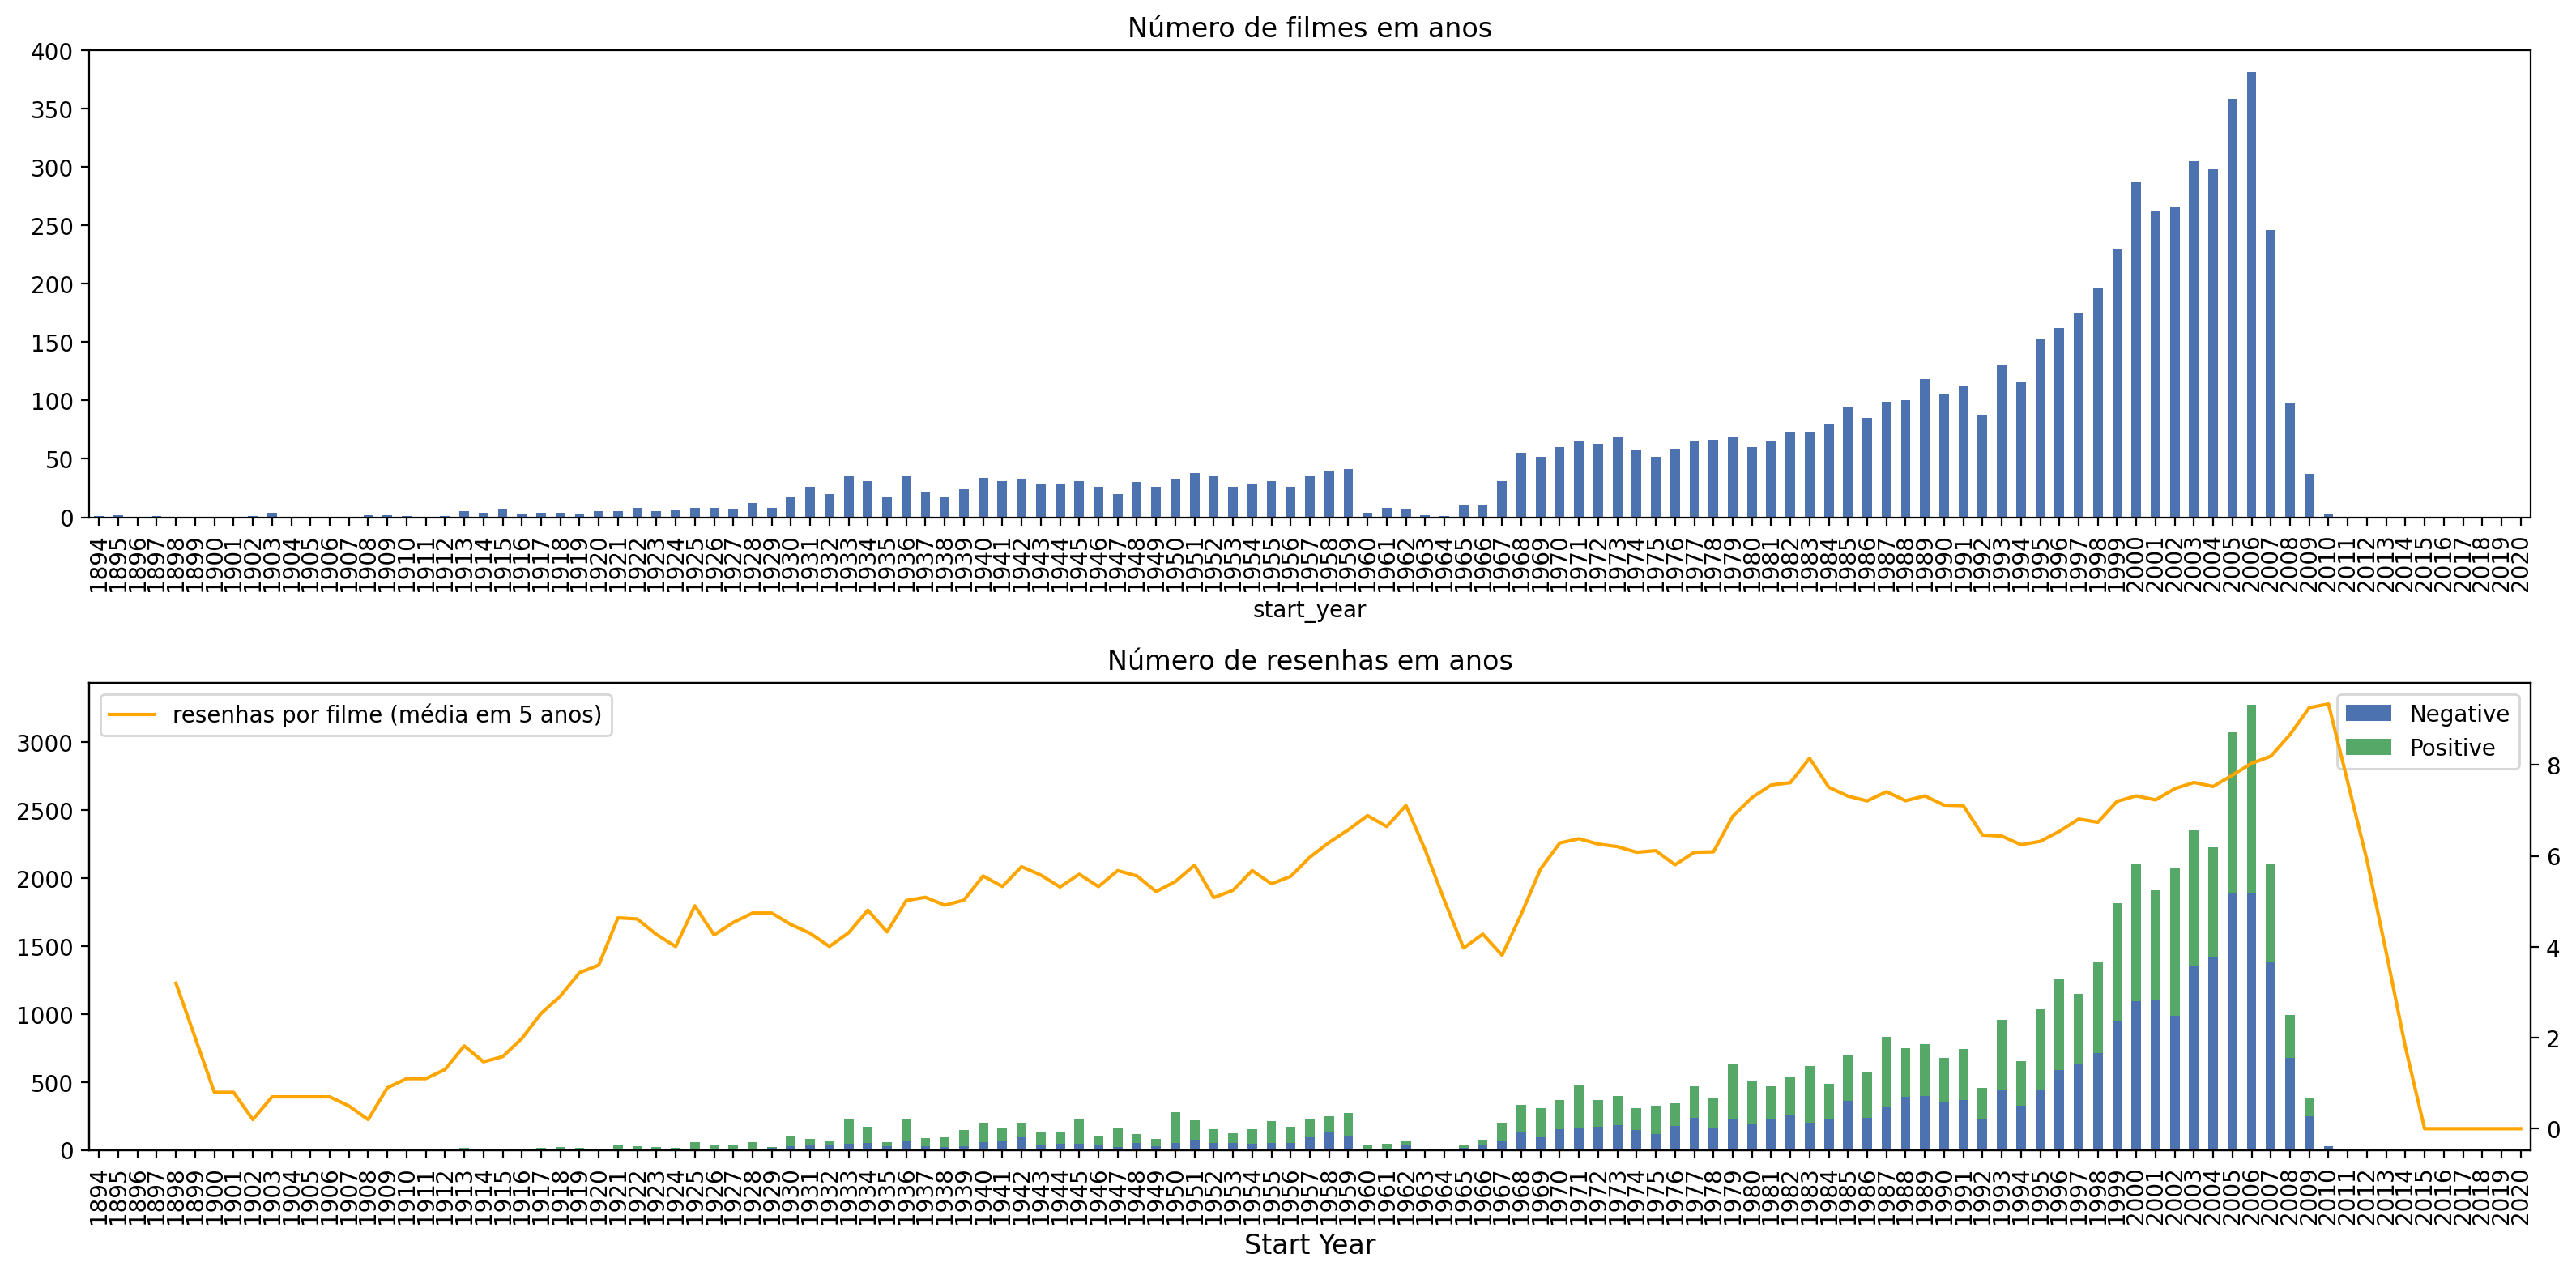

In [15]:
# Criando figuras com subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# setando o primeiro eixo
ax = axs[0]

# Criando o plot que mostra a quantidade de filmes lançados por ano
dft1 = (
    df_reviews[["tconst", "start_year"]]
    .drop_duplicates()["start_year"]
    .value_counts()
    .sort_index()
)
dft1 = dft1.reindex(
    index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))
).fillna(0)
dft1.plot(kind="bar", ax=ax)
ax.set_title("Número de filmes em anos")

# Setando o segundo eixo
ax = axs[1]

# Criando o plot que mostra a quantidade de filmes lançados por ano com as avaliações positivas e negativas
dft2 = df_reviews.groupby(["start_year", "pos"])["pos"].count().unstack()
dft2 = dft2.reindex(
    index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))
).fillna(0)
dft2.plot(kind="bar", stacked=True, label=["neg", "pos"], ax=ax)
axs[1].legend(labels=["Negative", "Positive"], loc=0)

# Criando a média móvel (5 anos) para o total de revisões
dft2 = df_reviews["start_year"].value_counts().sort_index()
dft2 = dft2.reindex(
    index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))
).fillna(0)
dft3 = (dft2 / dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(
    color="orange", label="resenhas por filme (média em 5 anos)", ax=axt
)
axt.legend(loc=0)
ax.set_title("Número de resenhas em anos")
ax.set_xlabel("Start Year", fontsize=12)
fig.tight_layout()

Os gráficos acima nos permitem visualizar o número de filmes lançados e as críticas feitas a cada ano. O primeiro gráfico mostra o total de filmes lançados por ano, enquanto o segundo mostra a média anual de críticas de filmes, com críticas positivas em verde e negativas em azul; adicionalmente, o segundo gráfico mostra uma média móvel de críticas por filme em uma janela de 5 anos.

Como podemos ver, as informações no nosso DataFrame sugerem que 2006 foi o ano com o maior número de filmes lançados. Isso coincide com o ano em que foram feitas mais críticas de filmes.

**Examinando a distribuição das reviews totais por filme**

Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

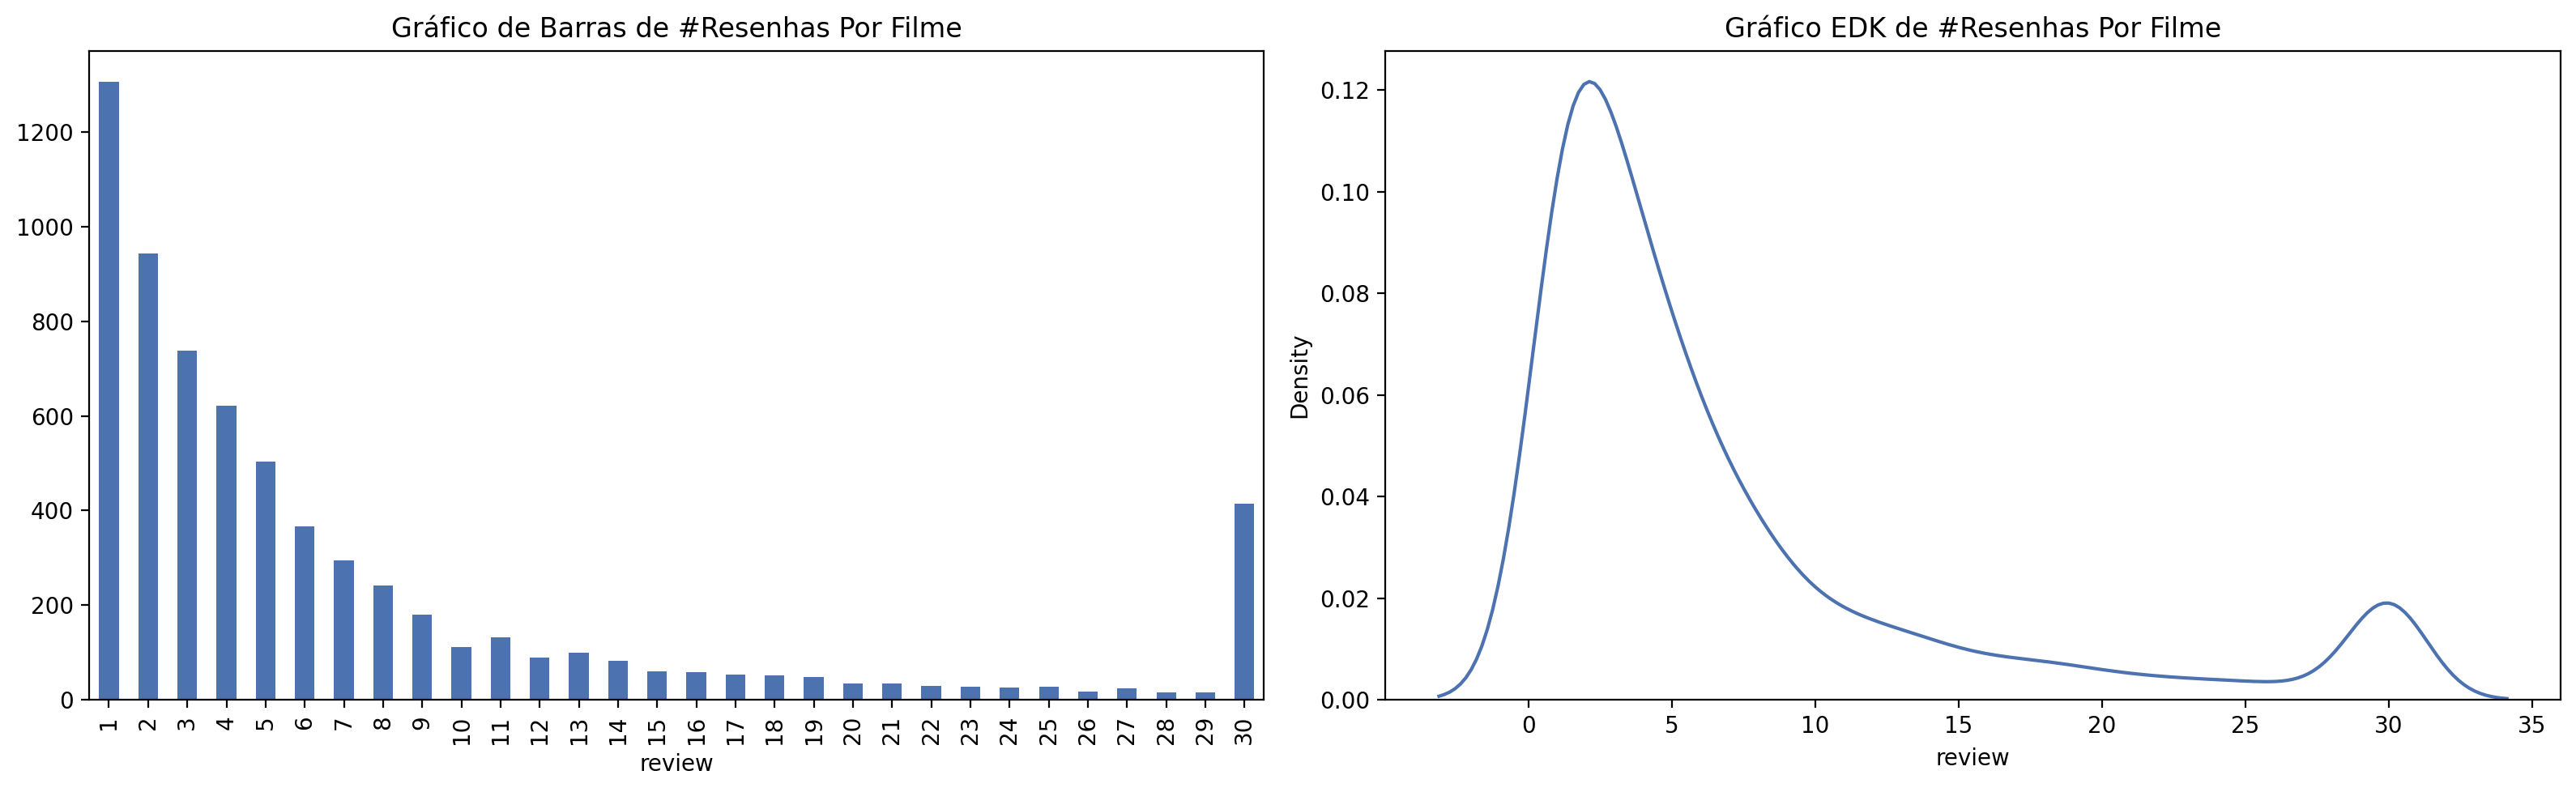

In [16]:
# Criando figura com subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# setando o primeiro eixo
ax = axs[0]

# Agrupando filmes por título e contar o número total de críticas
dft = df_reviews.groupby("tconst")["review"].count().value_counts().sort_index()
dft.plot.bar(ax=ax)
ax.set_title("Gráfico de Barras de #Resenhas Por Filme")

# Setando o segundo eixo
ax = axs[1]

# Criando gráfico KDE para mostrar a frequência do total de críticas de filmes
dft = df_reviews.groupby("tconst")["review"].count()
sns.kdeplot(dft, ax=ax)
ax.set_title("Gráfico EDK de #Resenhas Por Filme")

fig.tight_layout()

Podemos perceber com os gráficos acima que:
- A maioria dos filmes tem um número baixo de críticas (menos de 10)
- A maioria dos filmes tem 1 crítica feita
- O número total de filmes com muitas críticas, tendem a diminuir, com exceção dos filmes que possuem 30 críticas feitas. Provavelmente estes são os filmes mais populares do dataframe.

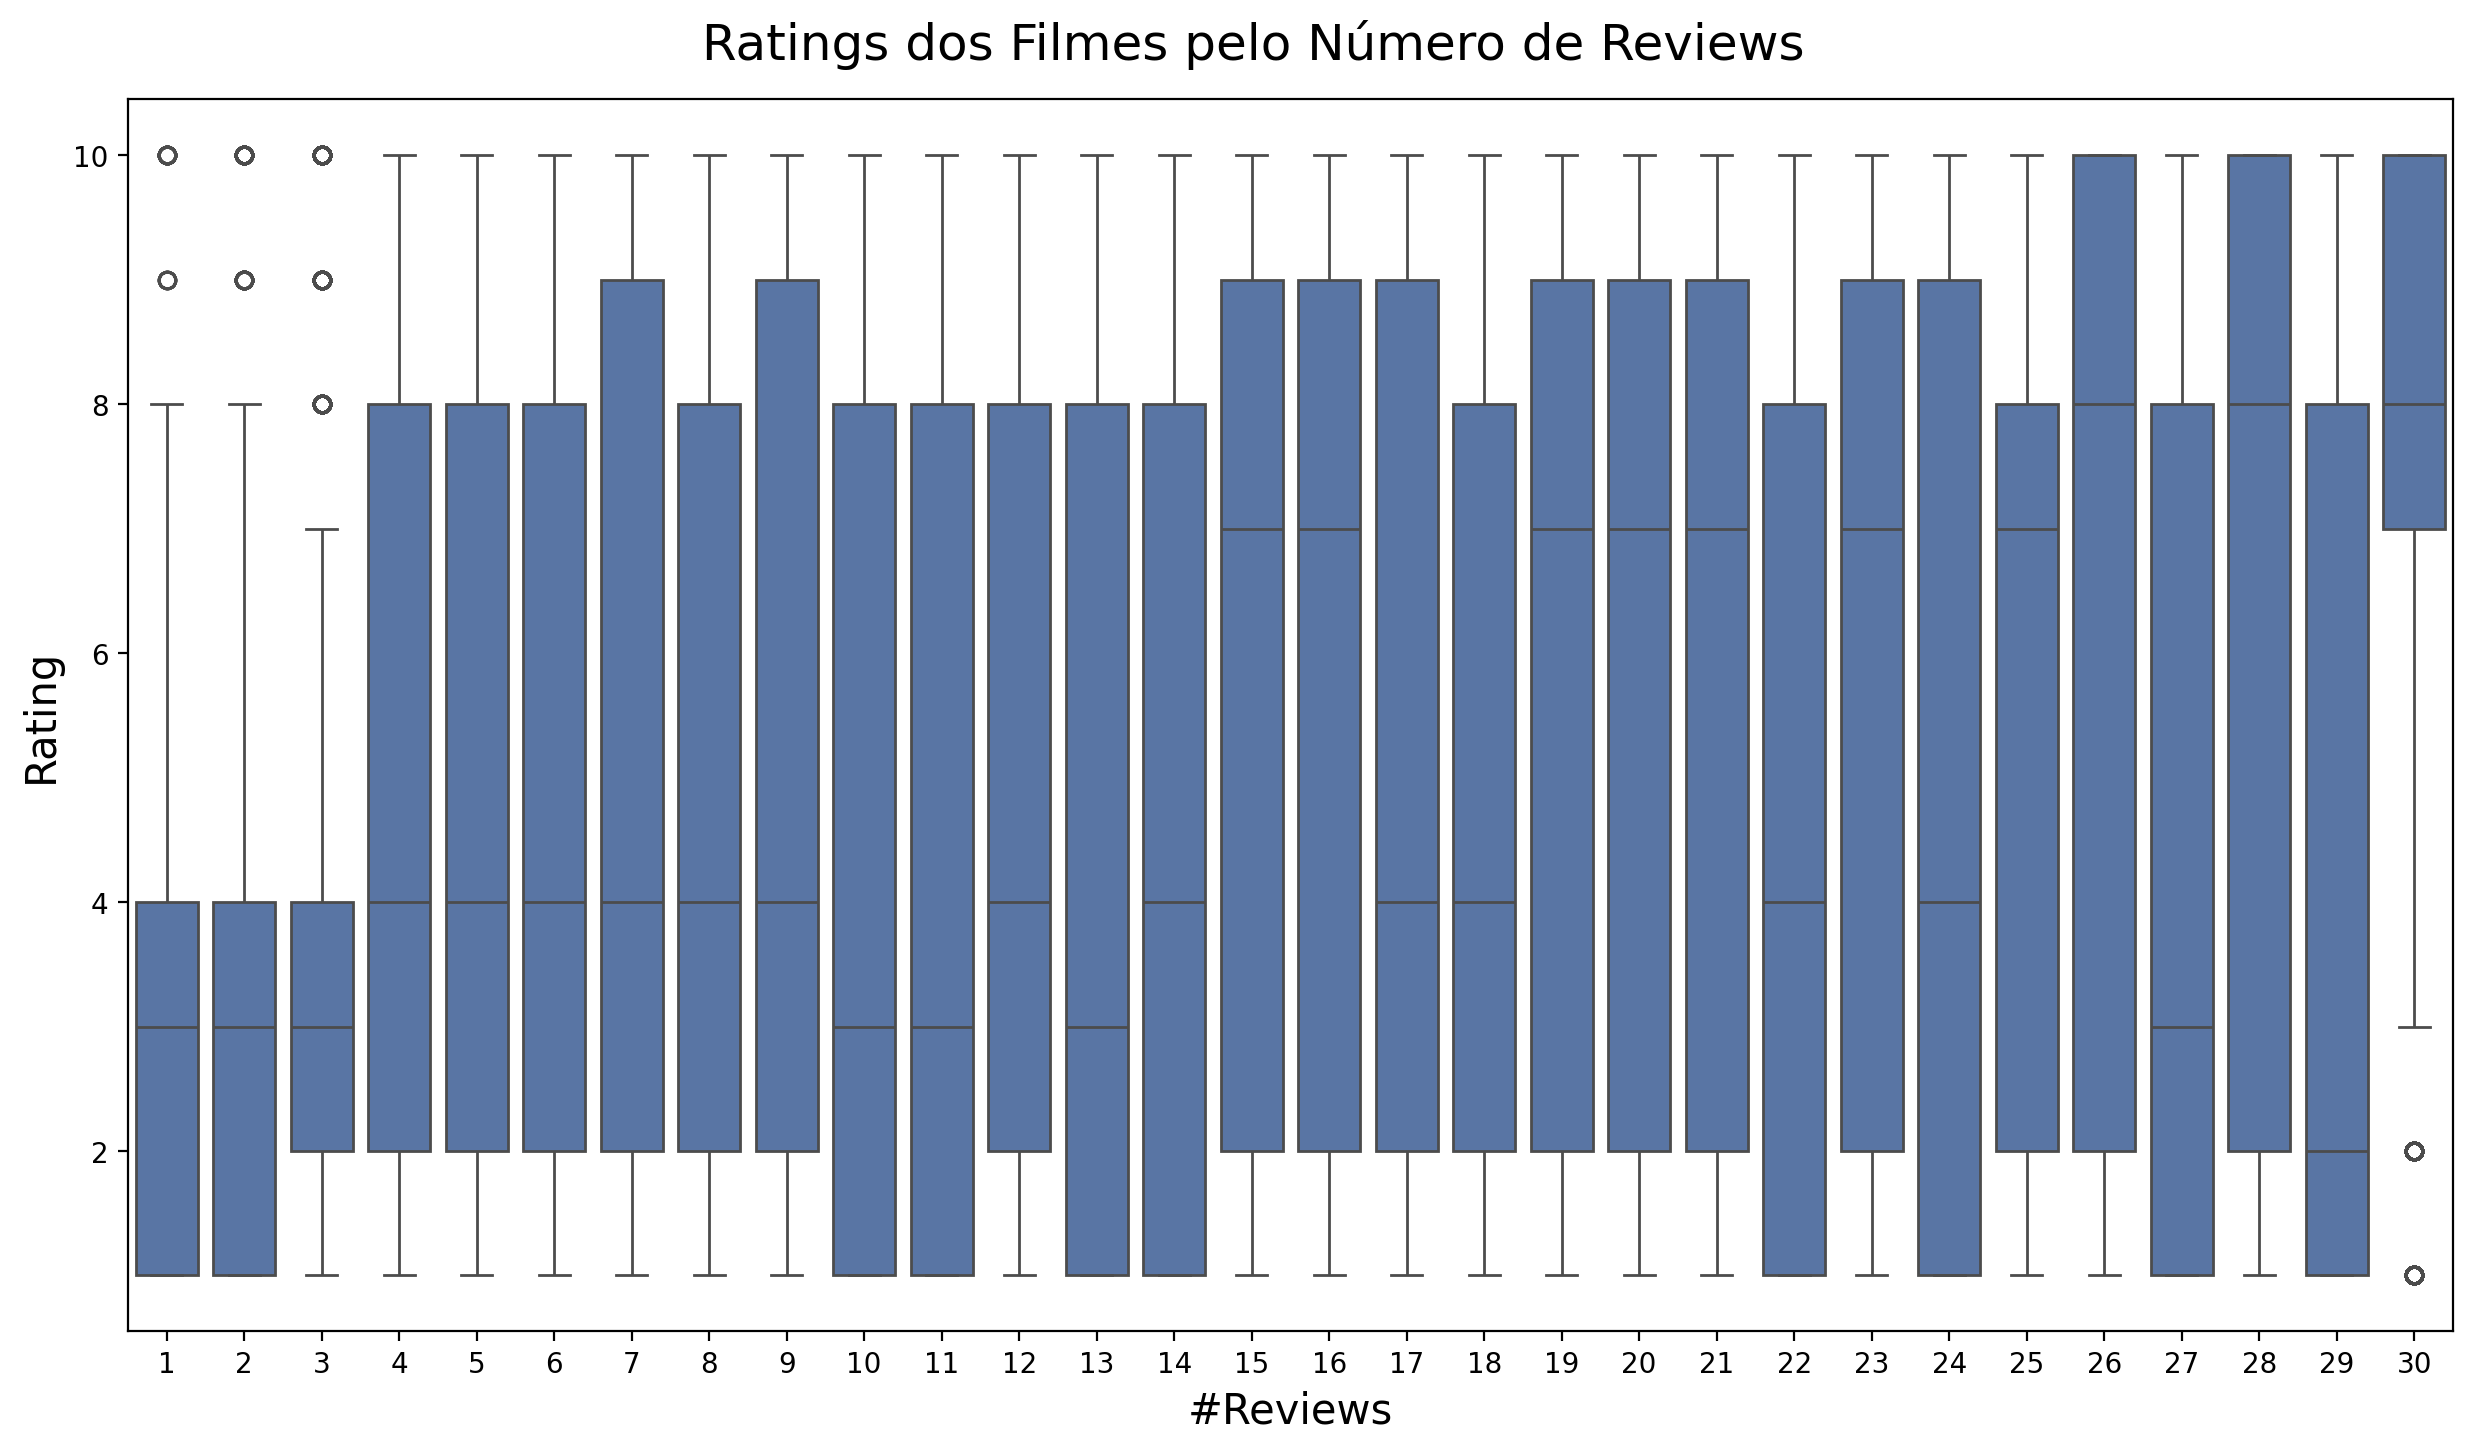

In [17]:
# Criando uma nova coluna para o total de review para cada filme
df_reviews["num_rev"] = df_reviews.groupby("tconst")["review"].transform("count")

# Criando boxplot para visualizar a média de rating por número de review dos filmes
fig = plt.figure(figsize=(15, 8))
sns.boxplot(x="num_rev", y="rating", data=df_reviews[["num_rev", "rating"]])
fig.suptitle("Ratings dos Filmes pelo Número de Reviews", fontsize=18, y=0.93)
plt.xlabel("#Reviews", fontsize=15)
plt.ylabel("Rating", fontsize=15)
plt.show()

- A partir deste boxplot, podemos ver uma certa tendência entre os filmes com um alto número de críticas - ou seja, eles parecem ter uma classificação média mais alta do que filmes com um número muito menor de críticas ou uma classificação mais baixa. A classificação média para filmes com entre 1 e 14 críticas parece estar entre 3 e 4. 

- Essas classificações tendem a oscilar em uma faixa mais alta para filmes com entre 15 e 25 críticas. Para filmes com entre 25 e 29 críticas, há uma variação de classificação média ainda maior - entre cerca de 2 e 8. 

- Finalmente, para filmes com 30 críticas, eles têm uma classificação média de 8. Curiosamente, a faixa interquartil de classificações para filmes com entre 1 e 3 críticas é a mais baixa, enquanto a faixa interquartil de classificações para filmes com 30 críticas é a mais alta. 

- Com tudo isso considerado, parece que filmes com 30 críticas tendem a ter as classificações mais altas, o que pode indicar que são altamente populares.

**Distribuição de Ratings e Reviews Positivos / Negativos**

In [18]:
# Print dos reviews positivos e negativos
print(f"Review Totais de Negativos e Positivos no Dataset Original:")
display(df_reviews["pos"].value_counts().reset_index(drop=True))

print(f"\nReview Totais de Negativos e Positivos no Conjunto de Dados de Treino:")
display(
    df_reviews.query('ds_part == "train"')["pos"].value_counts().reset_index(drop=True)
)

print(f"\nReview Totais de Negativos e Positivos no Conjunto de Dados de Teste:")
display(
    df_reviews.query('ds_part == "test"')["pos"].value_counts().reset_index(drop=True)
)

Review Totais de Negativos e Positivos no Dataset Original:


0    23715
1    23616
Name: count, dtype: int64


Review Totais de Negativos e Positivos no Conjunto de Dados de Treino:


0    11912
1    11884
Name: count, dtype: int64


Review Totais de Negativos e Positivos no Conjunto de Dados de Teste:


0    11803
1    11732
Name: count, dtype: int64

Podemos ver que os dados positivos e negativos estão de certa forma balanceados.

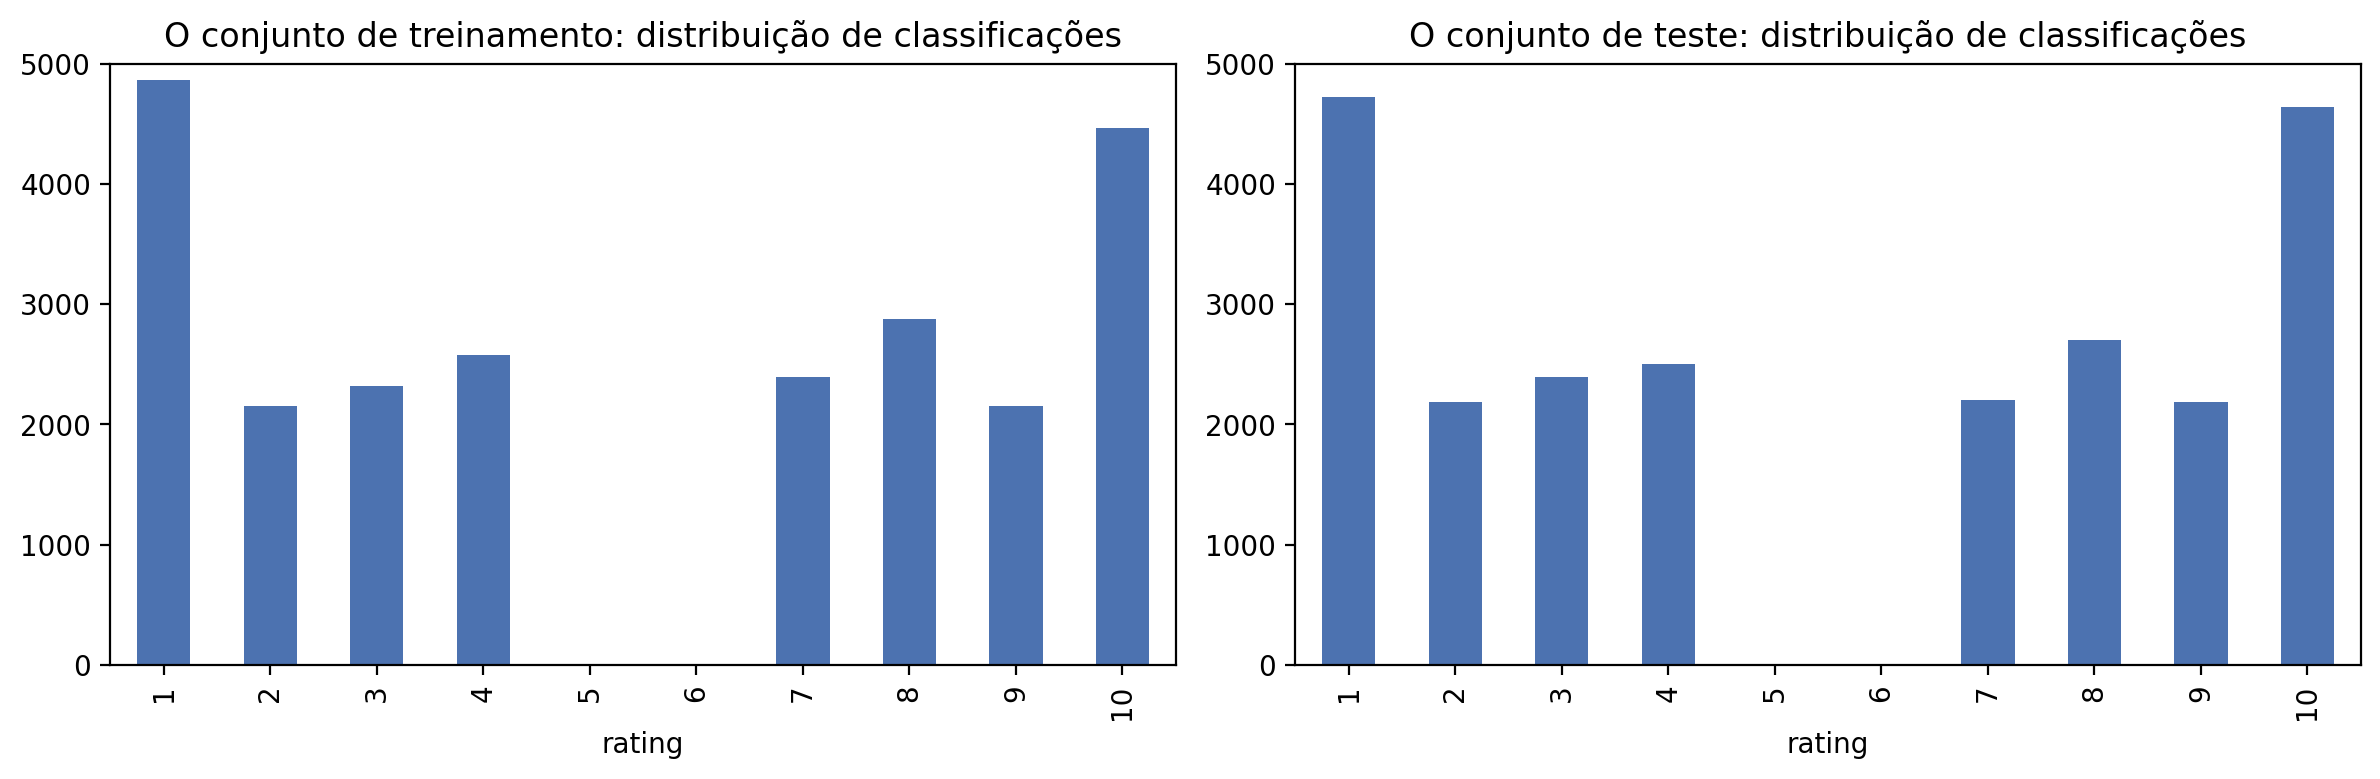

In [19]:
# Criando figura e subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Set do primeiro eixo
ax = axs[0]

# Obtendo os valores para os ratings para a coluna "train"
dft = df_reviews.query('ds_part == "train"')["rating"].value_counts().sort_index()
dft = dft.reindex(
    index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))
).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title("O conjunto de treinamento: distribuição de classificações")

# Set do segundo eixo
ax = axs[1]

# Obtendo os valores para os ratings para a coluna "test"
dft = df_reviews.query('ds_part == "test"')["rating"].value_counts().sort_index()
dft = dft.reindex(
    index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))
).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title("O conjunto de teste: distribuição de classificações")

fig.tight_layout()

De ambos os conjuntos de dados, as classificações dos filmes são entre 1 - 4 e 7 - 10. Não há avaliações de classificações de 5 ou 6 nestes conjuntos de dados.

**Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados**

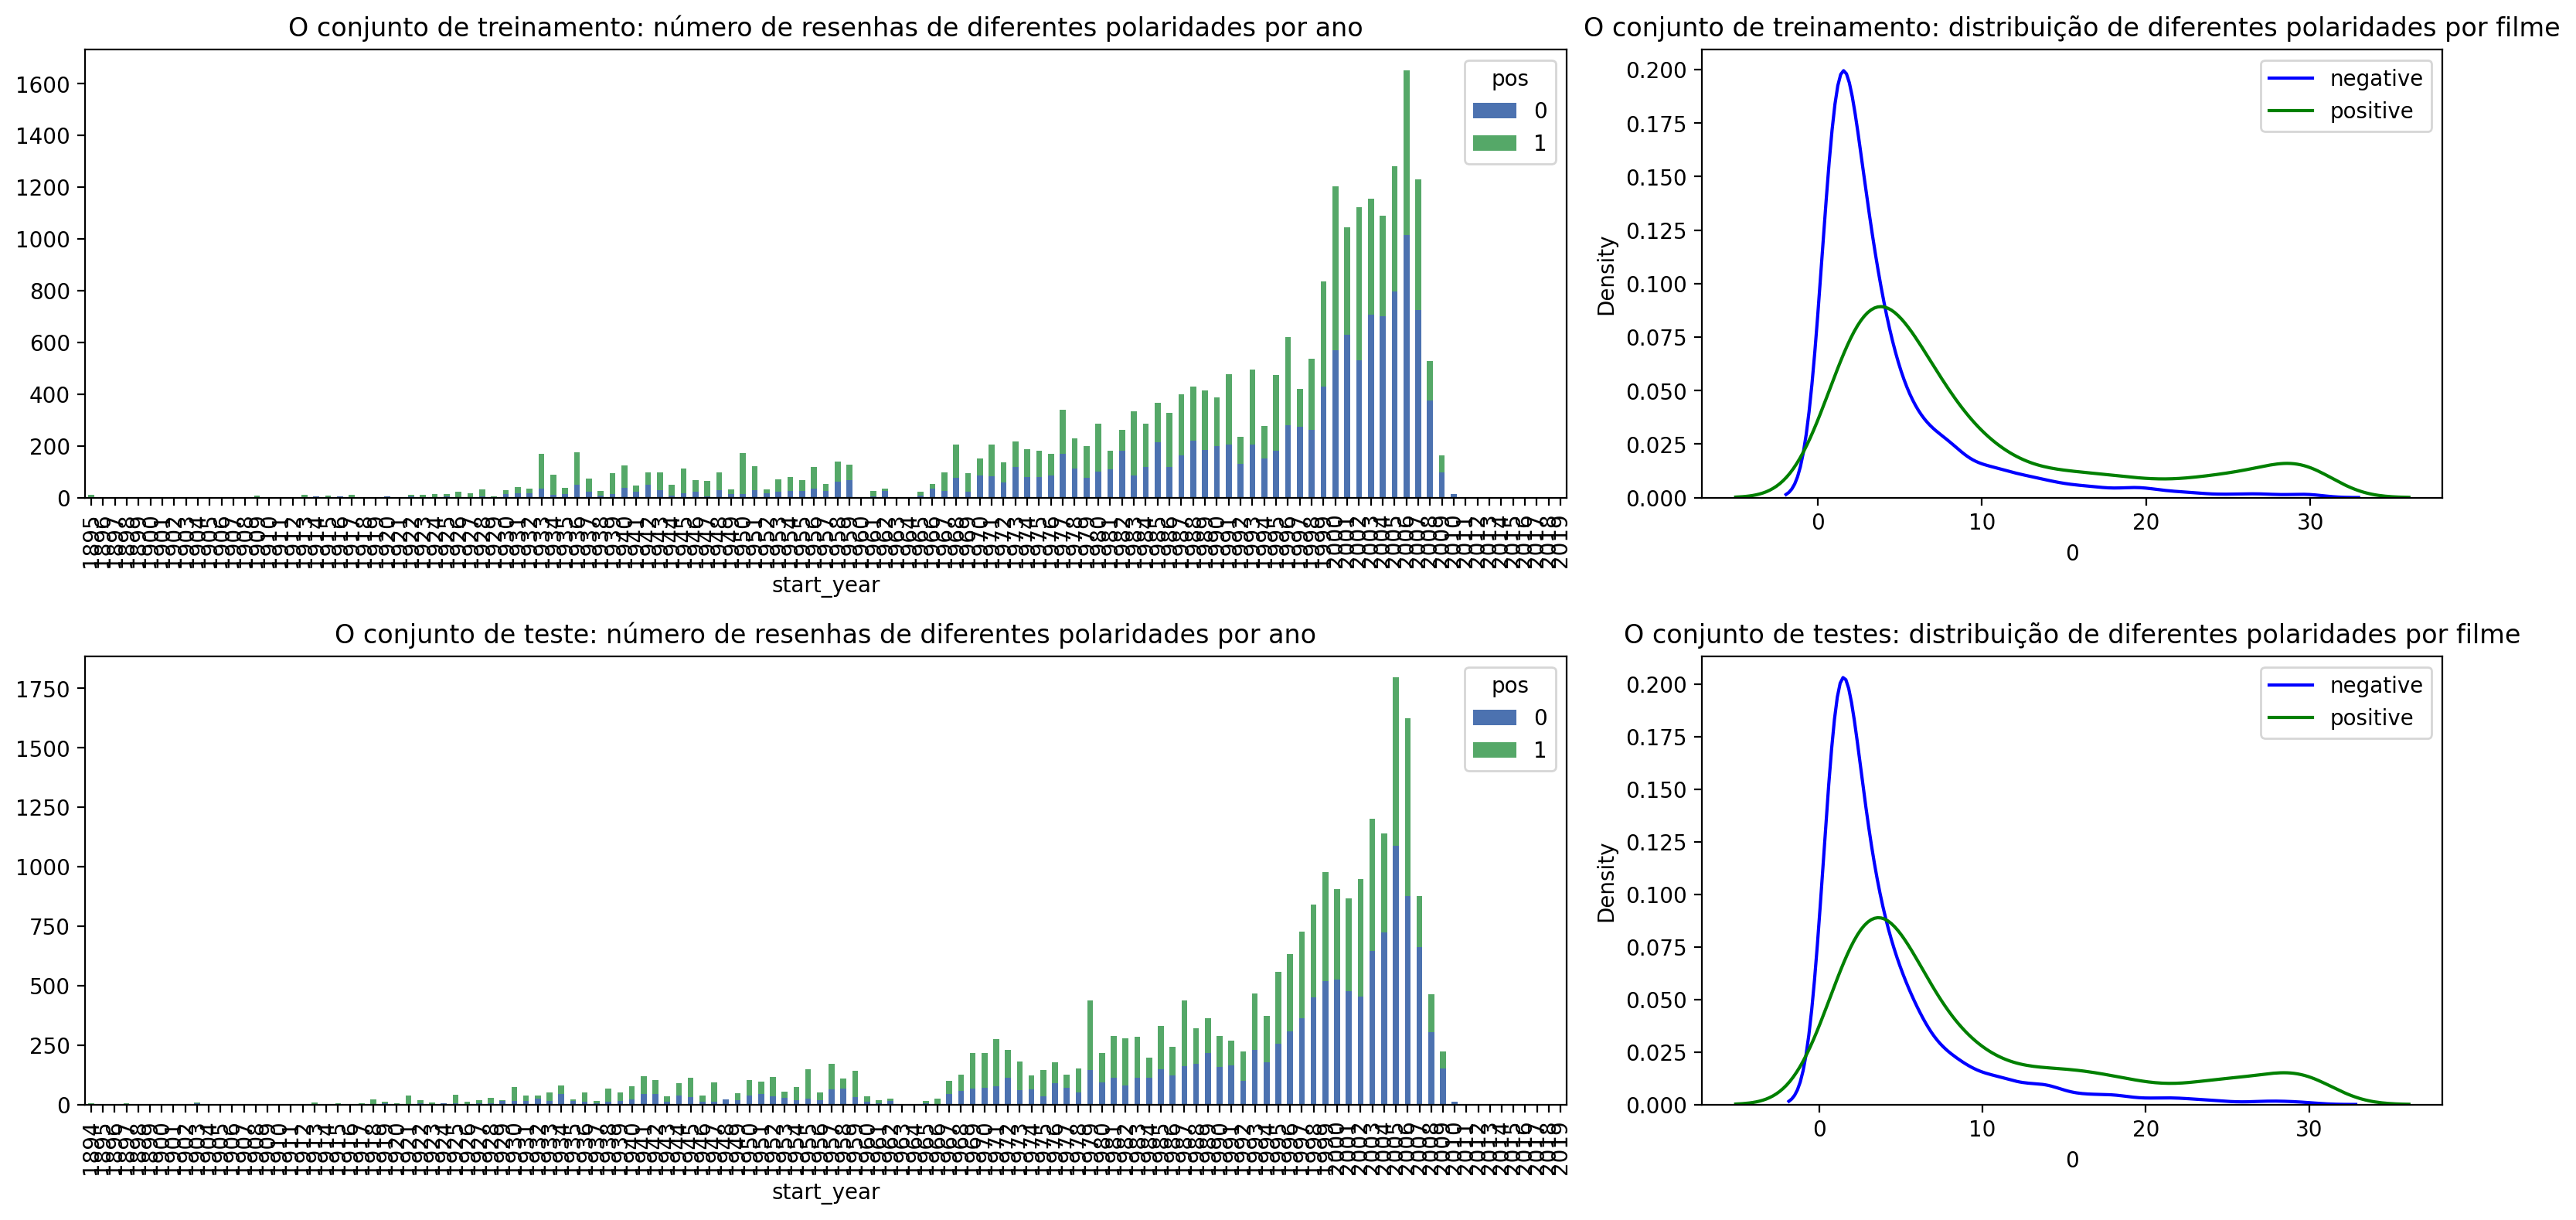

In [20]:
# Criando a figura e os subplots
fig, axs = plt.subplots(
    2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1))
)

# setando o primeiro eixo
ax = axs[0][0]

# Criando bar plot para visualizar a distribuição por ano
dft = (
    df_reviews.query('ds_part == "train"')
    .groupby(["start_year", "pos"])["pos"]
    .count()
    .unstack()
)
dft.index = dft.index.astype("int")
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(
    0
)
dft.plot(kind="bar", stacked=True, ax=ax)
ax.set_title(
    "O conjunto de treinamento: número de resenhas de diferentes polaridades por ano"
)

# setando o segundo eixo
ax = axs[0][1]

# Criando KDE plot para visualizar a distribuição
dft = (
    df_reviews.query('ds_part == "train"')
    .groupby(["tconst", "pos"])["pos"]
    .count()
    .unstack()
)
sns.kdeplot(dft[0], color="blue", label="negative", kernel="epa", ax=ax)
sns.kdeplot(dft[1], color="green", label="positive", kernel="epa", ax=ax)
ax.legend()
ax.set_title(
    "O conjunto de treinamento: distribuição de diferentes polaridades por filme"
)

# setando o terceiro eixo
ax = axs[1][0]

# Criando bar plot para visualizar a distribuição por ano
dft = (
    df_reviews.query('ds_part == "test"')
    .groupby(["start_year", "pos"])["pos"]
    .count()
    .unstack()
)
dft.index = dft.index.astype("int")
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(
    0
)
dft.plot(kind="bar", stacked=True, ax=ax)
ax.set_title(
    "O conjunto de teste: número de resenhas de diferentes polaridades por ano"
)

# setando o quarto eixo
ax = axs[1][1]

# Criando KDE plot para visualizar a distribuição
dft = (
    df_reviews.query('ds_part == "test"')
    .groupby(["tconst", "pos"])["pos"]
    .count()
    .unstack()
)
sns.kdeplot(dft[0], color="blue", label="negative", kernel="epa", ax=ax)
sns.kdeplot(dft[1], color="green", label="positive", kernel="epa", ax=ax)
ax.legend()
ax.set_title("O conjunto de testes: distribuição de diferentes polaridades por filme")

fig.tight_layout()

- A partir desses graficos podemos ver que o número de reviews feitas aumentou muito nas ultimas duas décadas

- A proporção da distribuição das críticas é mais equilibrada com as datas de lançamento mais pra frente

- Pelo gráfico de Kde podemos observar que há um numero maior de reviews negativos para filmes com menos criticas no total do que para aqueles filmes com muitos reviews.

- O padrão se assemelha com as reviews positivas, embora pareça que para cada conjunto de dados a probabilidade de uma crítica ser positiva é maior do que a probabilidade de ser negativa para filmes com 5 ou mais críticas

- No geral, a distribuição das avaliações, bem como a distribuição das avaliações positivas e negativas, parece muito semelhante tanto para os conjuntos de dados de treinamento quanto para os de teste.

## Procedimento de Avaliação

**Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto**

In [21]:
# Criando a função para avaliar o modelo
def evaluate_model(
    model_name, model, train_features, train_target, test_features, test_target
):

    # Dicionário para os resultados das avaliações
    eval_stats = {}

    # Cria a figura com subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f"{model_name} Model Evaluation", fontsize=18)

    # For loop para calcular as métricas
    for type, features, target in (
        ("Train", train_features, train_target),
        ("Test", test_features, test_target),
    ):

        eval_stats[type] = {}

        # Predição do modelo
        pred_target = model.predict(features)
        # Predição das probabilidades do modelo
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [
            metrics.f1_score(target, pred_proba >= threshold)
            for threshold in f1_thresholds
        ]

        # ROC-AUC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]["ROC AUC"] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(
            target, pred_proba
        )
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]["APS"] = aps

        if type == "Train":
            color = "blue"
        else:
            color = "green"

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(
            f1_thresholds,
            f1_scores,
            color=color,
            label=f"{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}",
        )
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = "orange" if threshold != 0.5 else "red"
            ax.plot(
                f1_thresholds[closest_value_idx],
                f1_scores[closest_value_idx],
                color=marker_color,
                marker="X",
                markersize=7,
            )
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel("Threshold")
        ax.set_ylabel("F1")
        ax.legend(loc="lower center")
        ax.set_title(f"Valor F1")

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f"{type}, ROC AUC={roc_auc:.2f}")
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = "orange" if threshold != 0.5 else "red"
            ax.plot(
                fpr[closest_value_idx],
                tpr[closest_value_idx],
                color=marker_color,
                marker="X",
                markersize=7,
            )
        ax.plot([0, 1], [0, 1], color="grey", linestyle="--")
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend(loc="lower center")
        ax.set_title(f"Curva ROC")

        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f"{type}, AP={aps:.2f}")
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = "orange" if threshold != 0.5 else "red"
            ax.plot(
                recall[closest_value_idx],
                precision[closest_value_idx],
                color=marker_color,
                marker="X",
                markersize=7,
            )
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend(loc="lower center")
        ax.set_title(f"PRC")

        # Adiciona os resultados no dicionário
        eval_stats[type]["Accuracy"] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]["F1"] = metrics.f1_score(target, pred_target)

    # Criando o dataframe com os resultados das métricas
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=("Accuracy", "F1", "APS", "ROC AUC"))

    display(df_eval_stats)

    return

- Esta função vai obter previsões dos modelos, assim como as probabilidades previstas, criando gráficos de ROC e Curva de Precisão-Revocação e calcular a métrica F1 em vários thresholds. As seguintes métricas serão mostradas:

    - **Precisão**: Número de previsões corretas sobre o total de previsões. Uma pontuação de alta precisão é boa quando há um número igual de observações pertencentes a cada classe.

    - **F1**: Média harmônica entre precisão e recall. Usamos a pontuação F1 para encontrar o equilíbrio ideal entre precisão e recall.

    - **APS**: Pontuação média de precisão em todos os limites. É essencialmente a área sob a pontuação de recuperação de precisão. Quanto maior a pontuação, melhor.

    - **ROC AUC**: A área sob a curva ROC, que representa graficamente a taxa de falsos positivos de um modelo em relação à sua taxa de verdadeiros positivos. Quanto maior a pontuação melhor o modelo.

## Treinar / Testar Conjunto

**Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.**

In [22]:
# Split dos dados de acordo com os valroes de ds_split
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Separando a coluna de target
train_target = df_reviews_train["pos"]
test_target = df_reviews_test["pos"]

# Criando as features dos datasets
train_features = df_reviews_train["review_norm"]
test_features = df_reviews_test["review_norm"]

print(f"Shape do dataset de Treinamento: {df_reviews_train.shape}")
print(f"Shape do dataset de Teste: {df_reviews_test.shape}")

Shape do dataset de Treinamento: (23796, 19)
Shape do dataset de Teste: (23535, 19)


- Os conjuntos de dados foram divididos de acordo com o valor de "ds_part" de cada observação.

- Para as variáveis objetivos, deixamos apenas a coluna "pos", que indica que a review é positiva ou negativa.

- Para as features, garantimos que as reviews foram normalizadas, ou seja, são reviews que tenham apenas letras e apóstrofos

## Trabalhando com modelos

### Modelo 0 - Constante

,Train,Test
Accuracy,0.5,0.5
F1,0.5,0.5
APS,0.5,0.5
ROC AUC,0.5,0.5


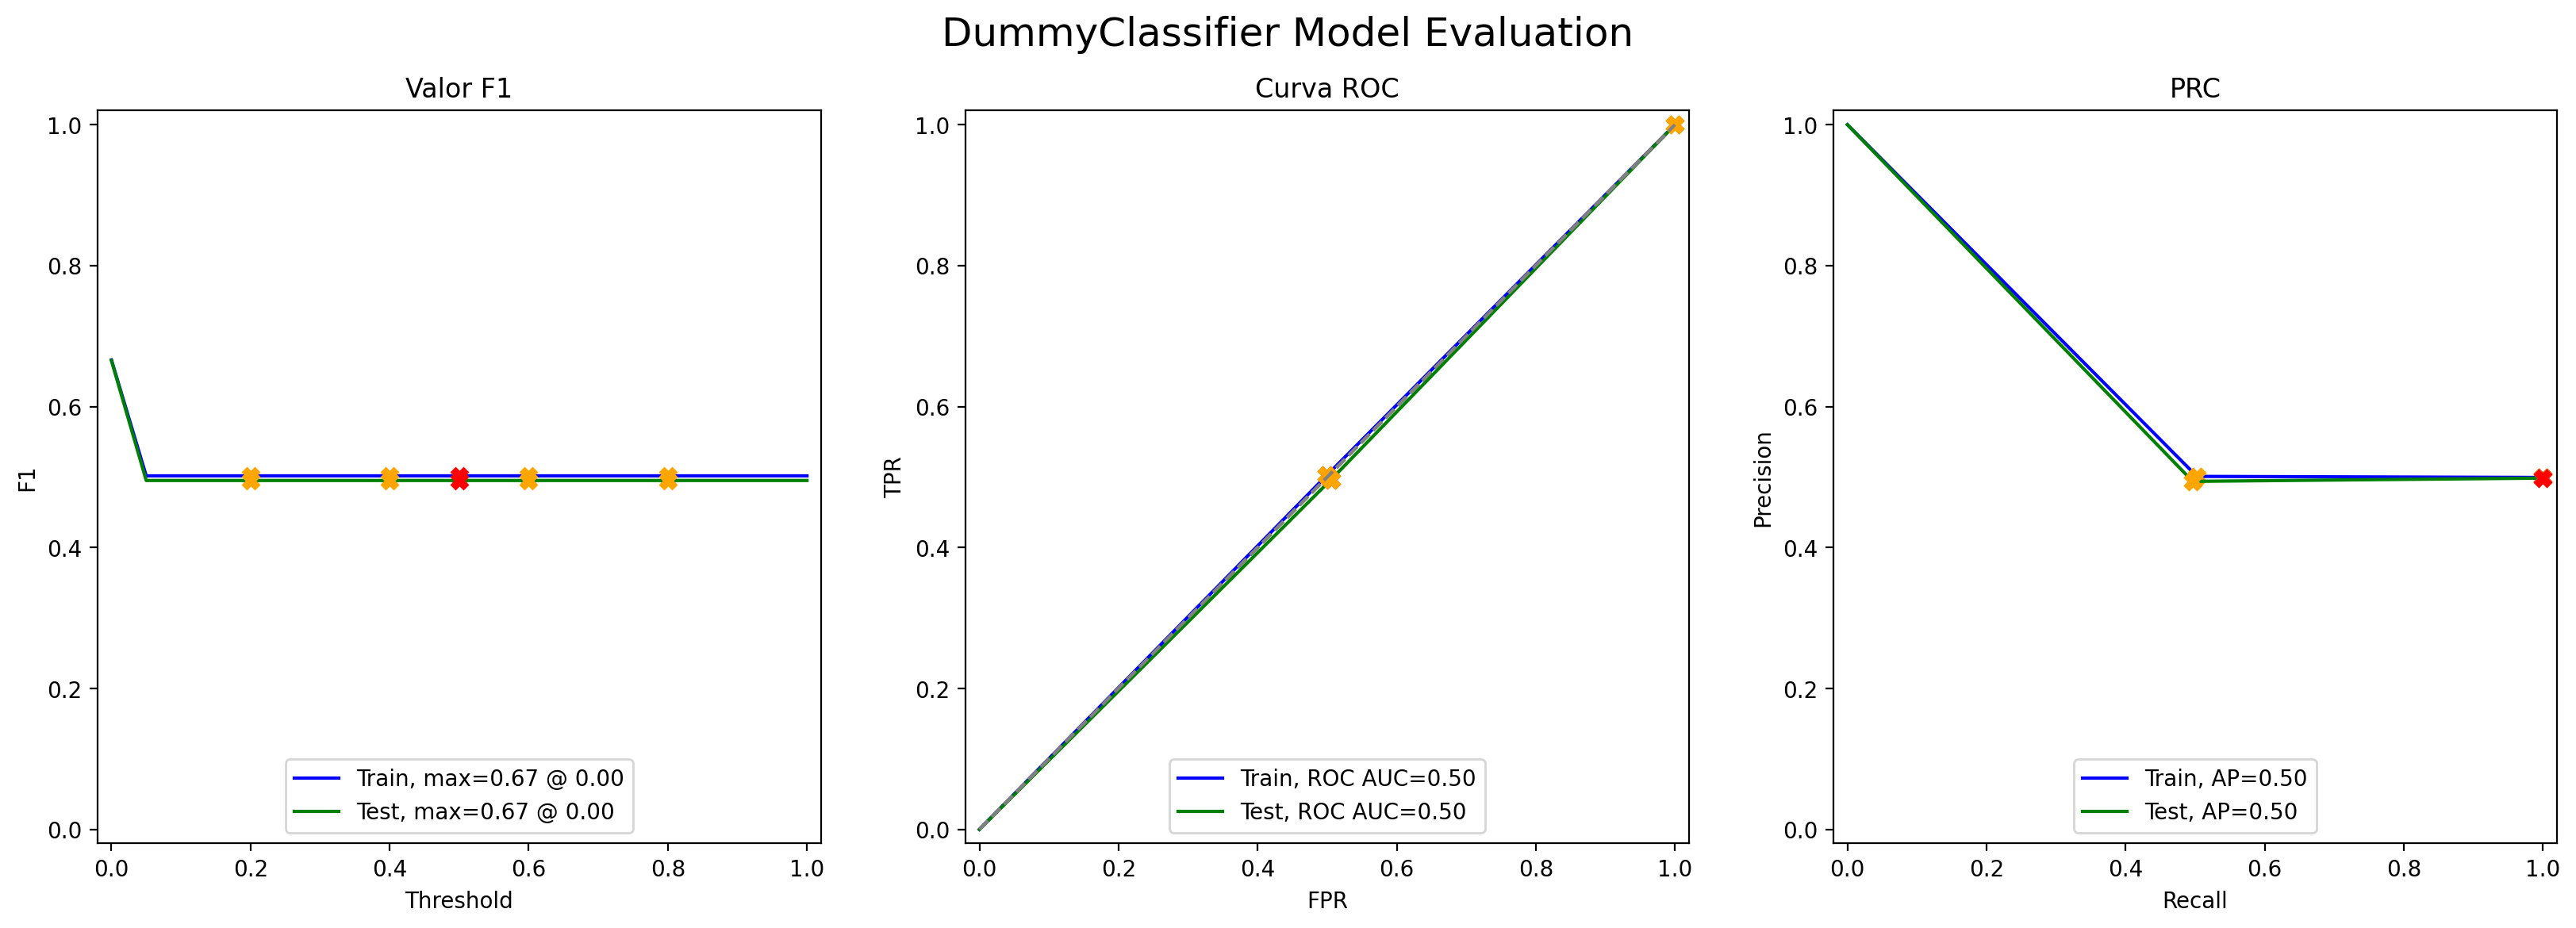

In [23]:
dummy_model = DummyClassifier(strategy="stratified", random_state=12345)
dummy_model.fit(train_features, train_target)

evaluate_model(
    "DummyClassifier",
    dummy_model,
    train_features,
    train_target,
    test_features,
    test_target,
)

- Como esperado, no modelo Dummy, as respostas corretas foram previstas com uma pontuação de Accuracy, F1, APS e ROC-AUC igual a 0.5

- Essas pontuações indicam que o modelo Dummy classifica as observações de uma maneira que não é o melhor para o caso, mas usaremos esse modelo como referência para determinar o desempenho dos próximos modelos.

### Modelo 1 - NLTK, TF-IDF e Regressão Logística

TF-IDF

In [24]:
# Criando a função para Lemmatizar
def lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized = " ".join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized

In [25]:
# lemmatizando as palavras
train_features_lemm_nltk = train_features.progress_apply(lemmatizer)
test_features_lemm_nltk = test_features.progress_apply(lemmatizer)

100%|██████████| 23535/23535 [00:29<00:00, 801.32it/s]


,Train,Test
Accuracy,0.94,0.88
F1,0.94,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


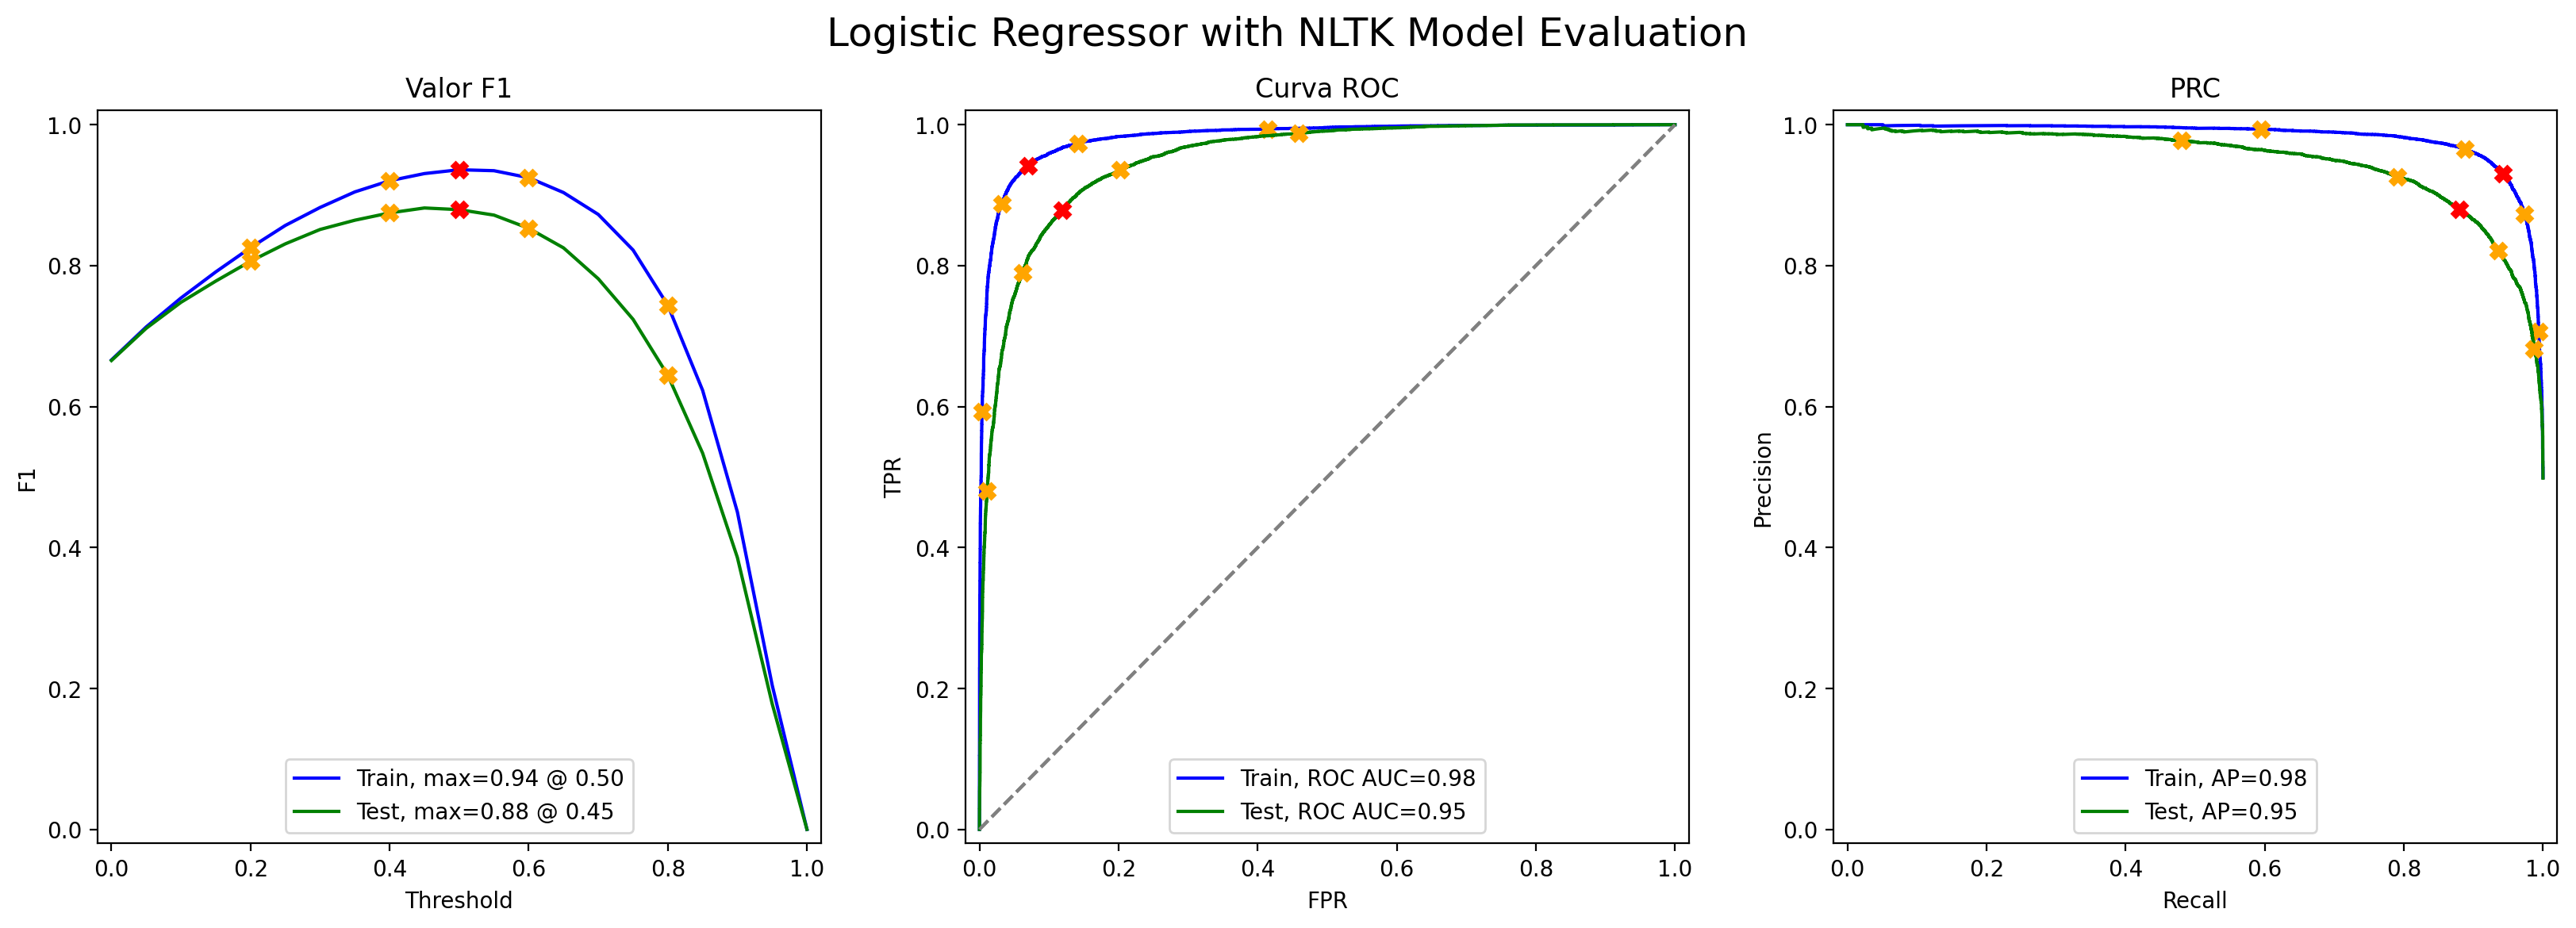

In [26]:
# Criando stopwords
stop_words = list(set(stopwords.words("english")))

# Criando vetor TF-IDF
model1_tf_idf = TfidfVectorizer(stop_words=stop_words)

# Fit do vetor com o conjunto de dados de treinamento
model1_train_features = model1_tf_idf.fit_transform(train_features_lemm_nltk)

# transfom do conjunto de teste
model1_test_features = model1_tf_idf.transform(test_features_lemm_nltk)

# Criando o modelo de Regressão Logistica
model1 = LogisticRegression(random_state=12345, solver="saga")
model1.fit(model1_train_features, train_target)

# Evaluate do modelo
evaluate_model(
    "Logistic Regressor with NLTK",
    model1,
    model1_train_features,
    train_target,
    model1_test_features,
    test_target,
)

- Como pode ser visto, o modelo de Regressão Logística teve desempenho melhor do que o modelo Dummy.

- Foi feita a lemmatização das palavras em cada uma das reviews nos conjuntos de dados de treinamento e teste.

- No conjunto de dados de treinamento, as métricas foram excelentes. Porém no conjunto de dados de teste, os valores foram um pouco abaixo comparado aos resultados do treinamento, mas mesmo assim, tendo pontuações elevadas.

- No conjunto de teste a métrica F1 igual à 0.88, ficando superior ao valor mínimo necessário (0.85)

### Modelo 2 - spaCy, TF-IDF e Regressão Logística

In [27]:
# Criando o objeto spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Obtendo os stopwords do spacy
stop_words = list(nlp.Defaults.stop_words)


# Criando função para lemmatizar palavras
def spacy_lemmatize(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(tokens)

In [28]:
# lemmatizando as palavras
train_features_lemm_spacy = train_features.progress_apply(spacy_lemmatize)
test_features_lemm_spacy = test_features.progress_apply(spacy_lemmatize)

100%|██████████| 23535/23535 [03:37<00:00, 108.01it/s]


,Train,Test
Accuracy,0.93,0.87
F1,0.93,0.87
APS,0.98,0.94
ROC AUC,0.98,0.95


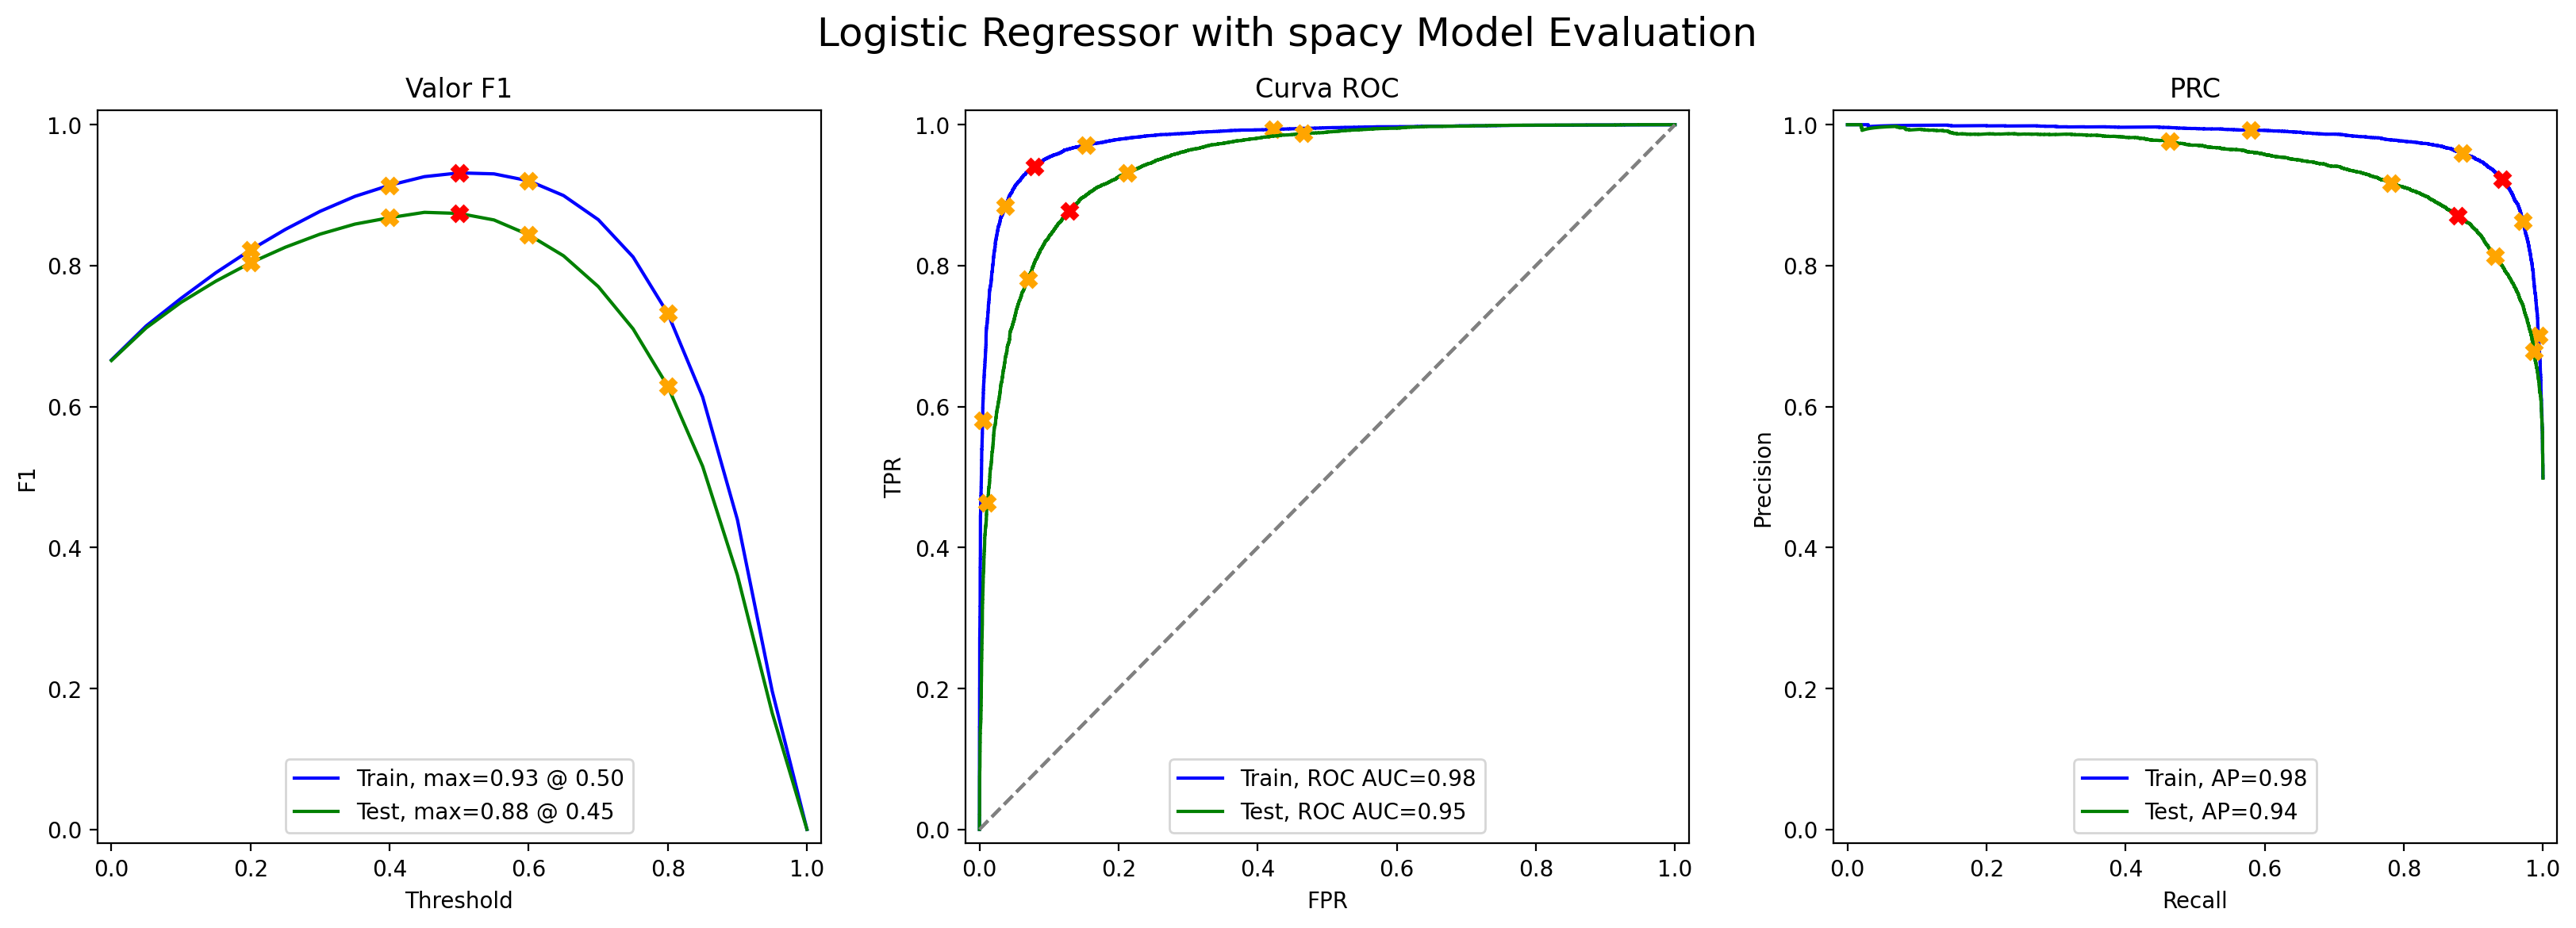

In [29]:
# Criando vetor TF-IDF
model2_tf_idf = TfidfVectorizer(stop_words=stop_words)

# Fit do vetor com o conjunto de dados de treinamento
model2_train_features = model2_tf_idf.fit_transform(train_features_lemm_spacy)

# transfom do conjunto de teste
model2_test_features = model2_tf_idf.transform(test_features_lemm_spacy)

# Criando o modelo de Regressão Logistica
model2 = LogisticRegression(random_state=12345, solver="saga")
model2.fit(model2_train_features, train_target)

# Evaluate do modelo
evaluate_model(
    "Logistic Regressor with spacy",
    model2,
    model2_train_features,
    train_target,
    model2_test_features,
    test_target,
)

- Usando o método de tokenização do spacy, o modelo teve resultado um pouco menor comparado ao método nltk, quase 0.01 ponto para cada métrica.

- O modelo teve uma pontuação do F1 de 0.87 para o conjunto de dados de teste, ficando acima do mínimo recomendado de 0.85

### Modelo 3 - SpaCy, TF-IDF e LGBMClassifier

  File "c:\Users\pedro\Desktop\Pedro\code\portfolio_projetos\imdb-reviews\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.364600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426369
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


,Train,Test
Accuracy,0.91,0.85
F1,0.91,0.85
APS,0.97,0.93
ROC AUC,0.97,0.93


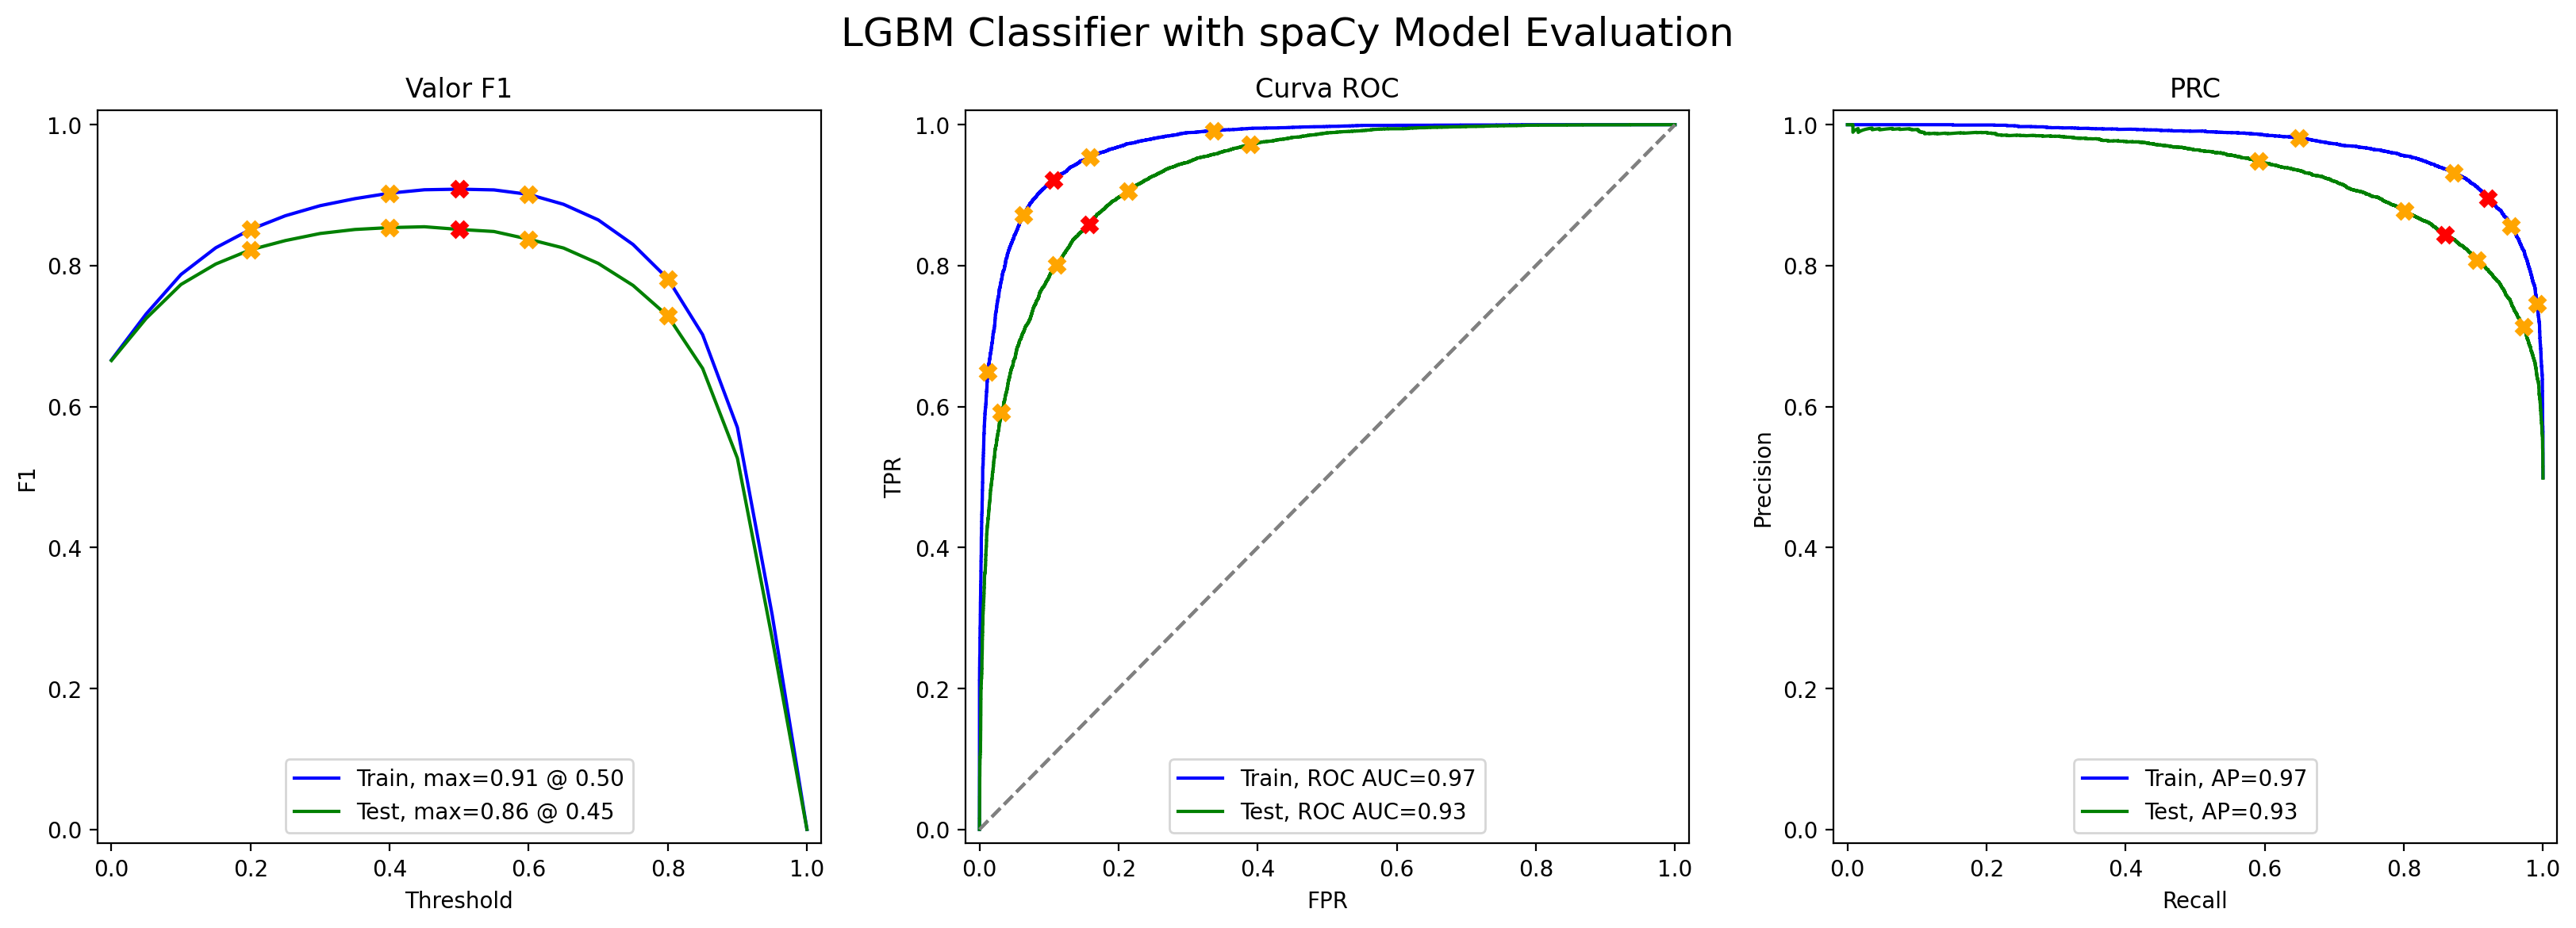

In [30]:
# Criando vetor TF-IDF
model3_tf_idf = TfidfVectorizer(stop_words=stop_words)

# Fit do vetor com o conjunto de dados de treinamento
model3_train_features = model3_tf_idf.fit_transform(train_features_lemm_spacy)

# transfom do conjunto de teste
model3_test_features = model3_tf_idf.transform(test_features_lemm_spacy)

# Criando o modelo LGBMClassifier
model3 = LGBMClassifier(random_state=12345)
model3.fit(model3_train_features, train_target)

# Evaluate do modelo
evaluate_model(
    "LGBM Classifier with spaCy",
    model3,
    model3_train_features,
    train_target,
    model3_test_features,
    test_target,
)

- O modelo LGBM parece ter resultados piores do que os resultados dos modelos anteriores

- Usando os mesmos conjuntos de dados, o modelo de regressão logística fornece pontuações mais altas para cada métrica do que nosso modelo de classificador LGBM

- A pontuação do F1 para o conjunto de dados de teste, ficou igual à 0.85, valor mínimo recomendado pela empresa Film Junky Union

###  Modelo 4 - BERT e Regressão Logística

In [31]:
# Iniciador do token BERT
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

# Configuração do BERT
config = transformers.BertConfig.from_pretrained("bert-base-uncased")
model = transformers.BertModel.from_pretrained("bert-base-uncased")

In [32]:
#  Função para criar embeddings para reviews
def BERT_text_to_embeddings(
    texts,
    train_or_test,
    max_length=512,
    batch_size=100,
    force_device=None,
    disable_progress_bar=False,
):

    # Criando lista para ids e attention_mask
    ids_list = []
    attention_mask_list = []

    # For loop para obter ids do tokenizer
    for review in tqdm(
        texts, disable=disable_progress_bar, desc=f"{train_or_test} Tokenizer Progress"
    ):
        # Tokenize review
        ids = tokenizer.encode(
            review, add_special_tokens=True, truncation=True, max_length=max_length
        )

        # Padd review to max_length.
        padded = np.array(ids + [0] * (max_length - len(ids)))

        # Criando attention_mask
        attention_mask = np.where(padded != 0, 1, 0)

        # Adicionando ids e mask para lista
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    # Especificando se deseja usar CPU ou GPU para processamento.
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    if not disable_progress_bar:
        print(f"Usando o dispositivo {device}.")

    # recebendo incorporações em lotes

    embeddings = []

    # For loop para obter incorporações em lotes
    for i in tqdm(
        range(math.ceil(len(ids_list) / batch_size)),
        disable=disable_progress_bar,
        desc=f"{train_or_test} Embeddings Progress",
    ):

        # Obtendo Ids batch
        ids_batch = torch.LongTensor(
            ids_list[batch_size * i : batch_size * (i + 1)]
        ).to(device)

        # Obtendo attention mask batch
        attention_mask_batch = torch.LongTensor(
            attention_mask_list[batch_size * i : batch_size * (i + 1)]
        ).to(device)

        # Avaliando o modelo sem gradiente
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(
                input_ids=ids_batch, attention_mask=attention_mask_batch
            )

        # Anexando incorporações. Obtenha apenas a saída do token CLS, que é o primeiro vetor de cada observação.
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    # Concatenando e retornando incorporação
    return np.concatenate(embeddings)

In [33]:
# Escolhendo os inputs e outputs dos arquivos para concatenar

input_files = [
    "datasets/features_bert_part/features_bert_part_aa",
    "datasets/features_bert_part/features_bert_part_ab",
    "datasets/features_bert_part/features_bert_part_ac",
    "datasets/features_bert_part/features_bert_part_ad",
    "datasets/features_bert_part/features_bert_part_ae",
    "datasets/features_bert_part/features_bert_part_af",

]  # Lista com os nomes dos arquivos divididos

output_file = "features_bert.npz"  # Nome do arquivo de saída

concatenate_files(input_files, output_file)

In [34]:
try:
    # Carregando dados incorporados de um arquivo salvo localmente
    with np.load("features_bert.npz") as data:
        train_features_BERT = data["train_features"]
        test_features_BERT = data["test_features"]
except:
    # Obtendo incorporações para conjuntos de treinamento e teste
    train_features_BERT = BERT_text_to_embeddings(train_features, "Training Set")
    test_features_BERT = BERT_text_to_embeddings(test_features, "Testing Set")

    # Salvando os embeddings para uso futuro
    np.savez_compressed(
        "features_bert.npz",
        train_features=train_features_BERT,
        test_features=test_features_BERT,
    )

,Train,Test
Accuracy,0.88,0.86
F1,0.88,0.86
APS,0.95,0.94
ROC AUC,0.95,0.94


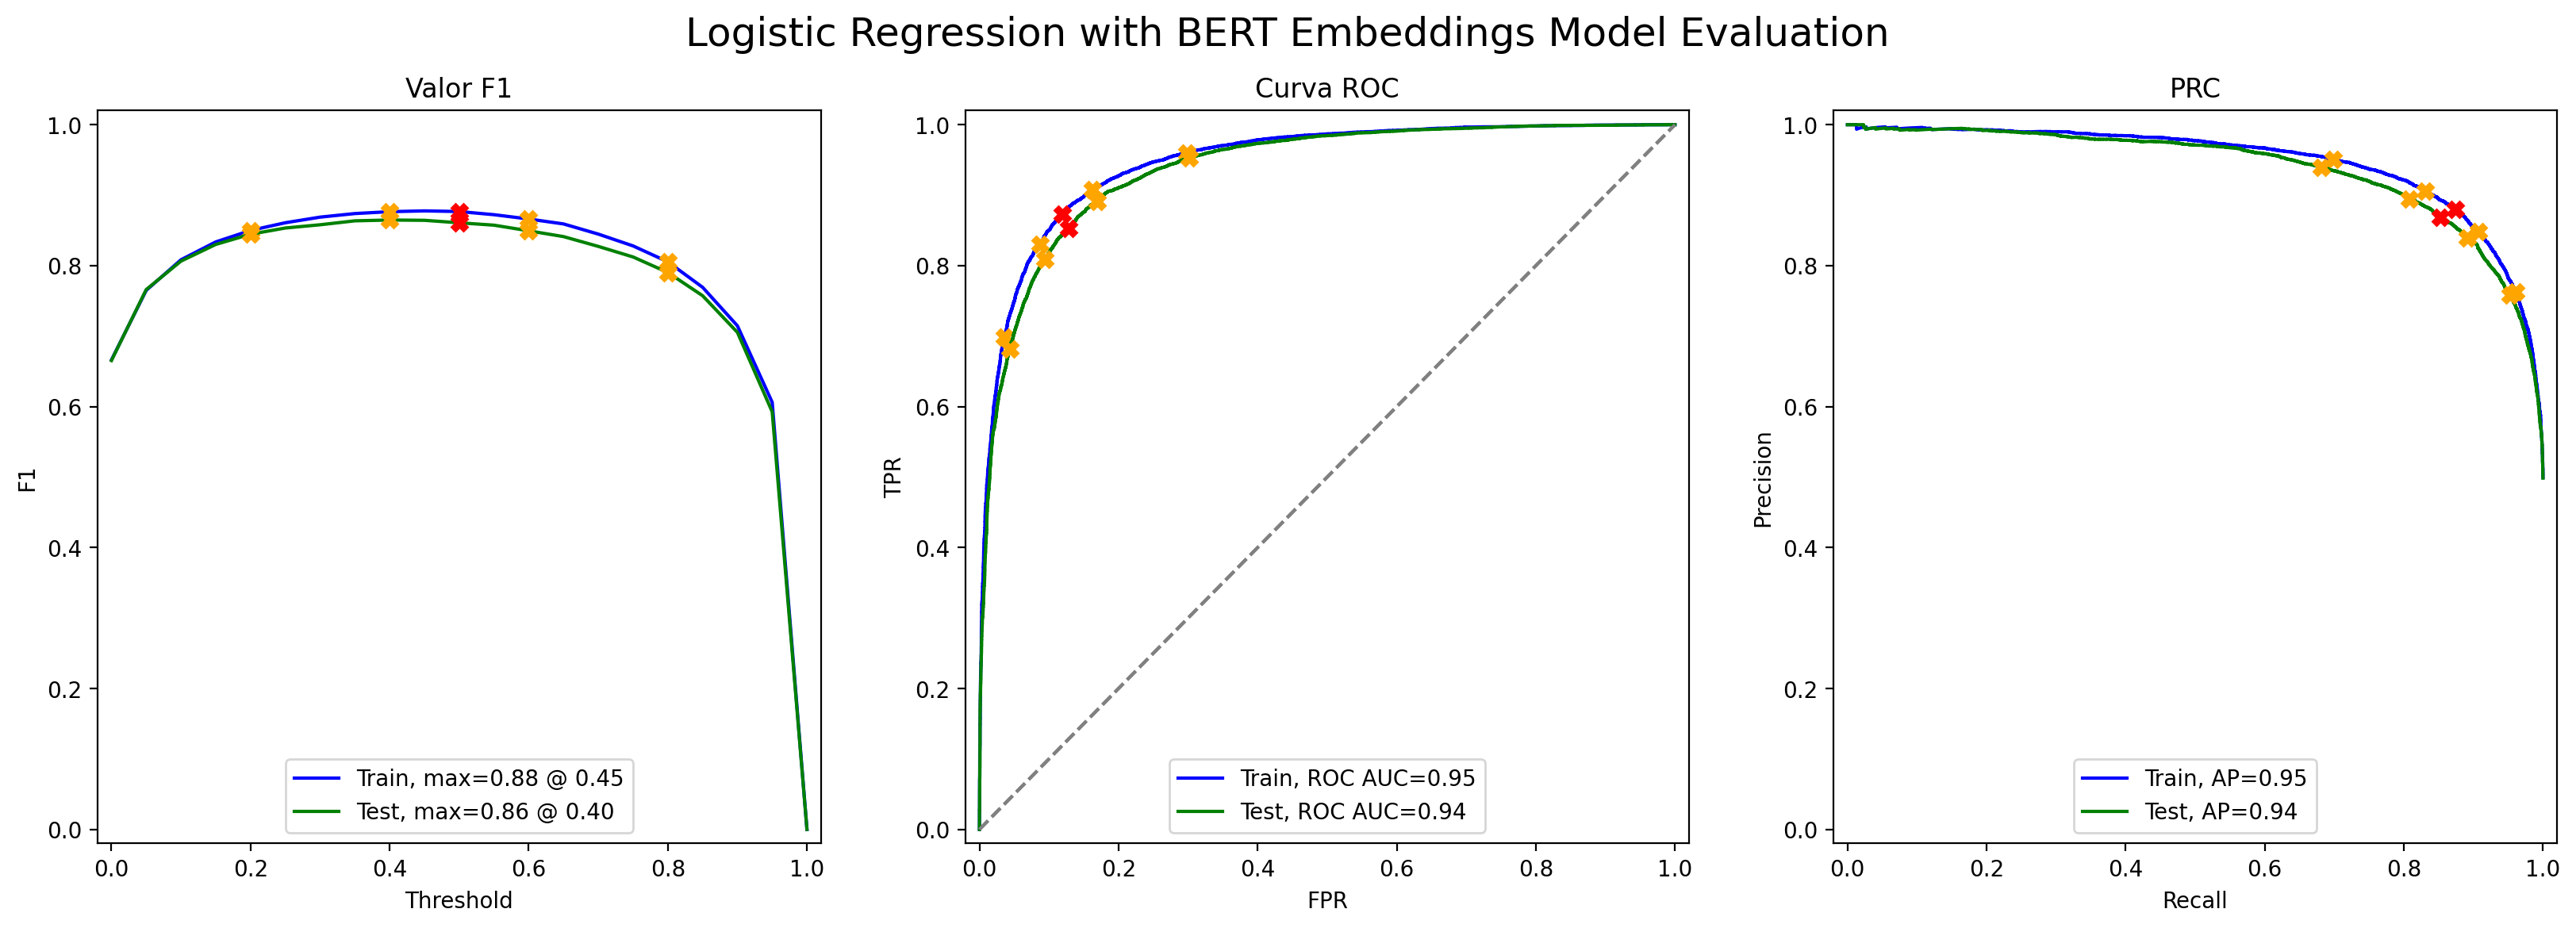

In [35]:
# Criando o modelo de Regressão Logistica
model4 = LogisticRegression(random_state=12345, solver="saga")
model4.fit(train_features_BERT, train_target)

# Evaluate do modelo
evaluate_model(
    "Logistic Regression with BERT Embeddings",
    model4,
    train_features_BERT,
    train_target,
    test_features_BERT,
    test_target,
)

- Com o modelo BERT e Regressão Logística, temos resultados que atende aos padrões da Film Junky Union, apresentando resultados para F1 igual à 0.86
- Esse modelo teve uma performance de resultados melhores que o modelo LGBM, e semelhantes aos modelos de Regressão Logística tokenizaods com NLTK e spaCy, por exemplo, porém, esse modelo demanda muito tempo para rodar a tokenização com o BERT, o que pode ser um diferencial na hora de escolher o melhor modelo.

## Conclusões dos Modelos

- Nesse estudo foram treinados diferentes modelos e usando diferentes métodos de NLP para converter texto em vetores. Esses métodos de tokenização foram: NLTK, spaCy e BERT, assim como a vetorização usando o TF-IDF.

- O modelo que obteve a melhor pontuação do F1 tanto para os conjuntos de treinamento quanto para os conjuntos de teste, foi o modelo que usa a combinação de NLTK, TF-IDF e Regressão Logística (Modelo 1), com a pontuação de 0.88. Além disso, teve um tempo significativamente menor para obter as previsões do modelo.

- Os outros modelos tiveram pontuações semelhantes, com a exceção do modelo Dummy.

## Minhas Resenhas

In [36]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame(
    [
        "Eu simplesmente não gostei, não é meu tipo de filme.",
        "Bem, eu fiquei entediado e dormi no meio do filme.",
        "Eu fiquei realmente fascinado com o filme",
        "Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do filme. Que roubo de dinheiro sem vergonha.",
        "Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o material original",
        "O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar indo assistir novamente.",
        "Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhenta, nem crianças não vão gostar disso!",
        "Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após episódio, deste emocionante e inteligente novo drama.",
    ],
    columns=["review"],
)

# Adicionando coluna às avaliações para indicar se as avaliações são positivas ou negativas
my_reviews["pos"] = [0, 0, 1, 0, 1, 1, 0, 1]

# Normalizando reviews
my_reviews["review_norm"] = my_reviews["review"].apply(clear_text)

my_reviews.head()

,review,pos,review_norm
0,"Eu simplesmente não gostei, não é meu tipo de ...",0,eu simplesmente n o gostei n o meu tipo de filme
1,"Bem, eu fiquei entediado e dormi no meio do fi...",0,bem eu fiquei entediado e dormi no meio do filme
2,Eu fiquei realmente fascinado com o filme,1,eu fiquei realmente fascinado com o filme
3,Os atores pareciam muito velhos e desinteressa...,0,os atores pareciam muito velhos e desinteressa...
4,Eu não esperava que a nova versão fosse tão bo...,1,eu n o esperava que a nova vers o fosse t o bo...


### Modelo 1 - NLTK, TF-IDF e Regressão Logística

In [37]:
# Lemmatizando reviews
texts = my_reviews["review_norm"].apply(lemmatizer)

# Vetorizando reviews e obtendo as predições do modelo
pred_prob = model1.predict_proba(model1_tf_idf.transform(texts))[:, 1]

# Print valores atual x preditado com as reviews de amostra
for i, review in enumerate(texts.str.slice(0, 100)):
    print(
        f"Actual: {my_reviews.pos[i]} | Predicted: {0 if pred_prob[i] < .5 else 1} | Text: {review[:50]}"
    )

Actual: 0 | Predicted: 1 | Text: eu simplesmente n o gostei n o meu tipo de filme
Actual: 0 | Predicted: 0 | Text: bem eu fiquei entediado e dormi no meio do filme
Actual: 1 | Predicted: 1 | Text: eu fiquei realmente fascinado com o filme
Actual: 0 | Predicted: 1 | Text: o atores pareciam muito velhos e desinteressados e
Actual: 1 | Predicted: 0 | Text: eu n o esperava que a nova vers o fosse t o boa o 
Actual: 1 | Predicted: 1 | Text: o filme tem seus pr s e contra ma eu sinto que em 
Actual: 0 | Predicted: 1 | Text: que tentativa podre de com dia nem uma nica piada 
Actual: 1 | Predicted: 1 | Text: lan ar na netflix foi uma jogada corajosa e eu rea


### Modelo 2 - spaCy, TF-IDF e Regressão Logística

In [38]:
# Lemmatizando reviews
texts = my_reviews["review_norm"].apply(spacy_lemmatize)

# Vetorizando reviews e obtendo as predições do modelo
pred_prob = model2.predict_proba(model2_tf_idf.transform(texts))[:, 1]

# Print valores atual x preditado com as reviews de amostra
for i, review in enumerate(texts.str.slice(0, 100)):
    print(
        f"Actual: {my_reviews.pos[i]} | Predicted: {0 if pred_prob[i] < .5 else 1} | Text: {review[:50]}"
    )

Actual: 0 | Predicted: 1 | Text: eu simplesmente n o gostei n o meu tipo de filme
Actual: 0 | Predicted: 0 | Text: bem eu fiquei entediado e dormi meio filme
Actual: 1 | Predicted: 1 | Text: eu fiquei realmente fascinado com o filme
Actual: 0 | Predicted: 1 | Text: os atore pareciam muito velhos e desinteressados e
Actual: 1 | Predicted: 0 | Text: eu n o esperava que nova ver o fosse t o boa os es
Actual: 1 | Predicted: 0 | Text: o filme tem seus pr s e contras mas eu sinto que e
Actual: 0 | Predicted: 1 | Text: que tentativa podre de com dia nem uma nica piada 
Actual: 1 | Predicted: 1 | Text: lan ar na netflix foi uma jogada corajosa e eu rea


### Modelo 3 - spaCy, TF-IDF e LGBMClassifier

In [39]:
# Lemmatizando reviews
texts = my_reviews["review_norm"]

# Vetorizando reviews e obtendo as predições do modelo
pred_prob = model3.predict_proba(model3_tf_idf.transform(texts))[:, 1]

# Print valores atual x preditado com as reviews de amostra
for i, review in enumerate(texts.str.slice(0, 100)):
    print(
        f"Actual: {my_reviews.pos[i]} | Predicted: {0 if pred_prob[i] < .5 else 1} | Text: {review[:50]}"
    )

Actual: 0 | Predicted: 1 | Text: eu simplesmente n o gostei n o meu tipo de filme
Actual: 0 | Predicted: 1 | Text: bem eu fiquei entediado e dormi no meio do filme
Actual: 1 | Predicted: 1 | Text: eu fiquei realmente fascinado com o filme
Actual: 0 | Predicted: 1 | Text: os atores pareciam muito velhos e desinteressados 
Actual: 1 | Predicted: 0 | Text: eu n o esperava que a nova vers o fosse t o boa os
Actual: 1 | Predicted: 1 | Text: o filme tem seus pr s e contras mas eu sinto que e
Actual: 0 | Predicted: 1 | Text: que tentativa podre de com dia nem uma nica piada 
Actual: 1 | Predicted: 1 | Text: lan ar na netflix foi uma jogada corajosa e eu rea


### Modelo 4 - BERT e Regressão Logística

In [40]:
# embeddings e obtendo a previsão de modelo
pred_prob = model4.predict_proba(
    BERT_text_to_embeddings(
        my_reviews["review_norm"], "Testing", disable_progress_bar=True
    )
)[:, 1]

# Print valores atual x preditado com as reviews de amostra
for i, review in enumerate(texts.str.slice(0, 100)):
    print(
        f"Actual: {my_reviews.pos[i]} | Predicted: {0 if pred_prob[i] < .5 else 1} | Text: {review[:50]}"
    )

Actual: 0 | Predicted: 1 | Text: eu simplesmente n o gostei n o meu tipo de filme
Actual: 0 | Predicted: 0 | Text: bem eu fiquei entediado e dormi no meio do filme
Actual: 1 | Predicted: 0 | Text: eu fiquei realmente fascinado com o filme
Actual: 0 | Predicted: 0 | Text: os atores pareciam muito velhos e desinteressados 
Actual: 1 | Predicted: 0 | Text: eu n o esperava que a nova vers o fosse t o boa os
Actual: 1 | Predicted: 0 | Text: o filme tem seus pr s e contras mas eu sinto que e
Actual: 0 | Predicted: 0 | Text: que tentativa podre de com dia nem uma nica piada 
Actual: 1 | Predicted: 1 | Text: lan ar na netflix foi uma jogada corajosa e eu rea


Visto que os modelos treinados foram para textos em lingua inglesa, ao alterar o idioma nas reviews "fictícias", as predições não foram 100% corretas. Porém, com o texto em inglês, tem resultados mais assertivos e mais precisos.

## Conclusões

- O objetivo deste projeto era desenvolver um modelo de aprendizado de máquina de PNL que pudesse classificar as resenhas de filmes de acordo com se são positivas ou negativas, com uma pontuação F1 não inferior a 0,85. 

- Ao realizar esta tarefa, primeiro pré-processamos nossos dados, o que incluiu a remoção de todas as revisões, exceto letras e apóstrofos. 

- Em seguida, realizamos análises exploratórias de dados, sendo um dos principais objetivos garantir que as classes sejam equilibradas entre conjuntos de dados de teste e treinamento; ao fazer isso, descobrimos que há um número quase igual de críticas positivas e negativas no conjunto de dados, bem como que há uma distribuição aproximadamente igual de avaliações de filmes em cada conjunto de dados. 

- Em seguida, construímos e testamos uma série de redes neurais, cada uma delas envolvendo algum tipo de processo de lematização e tokenização (exceto para o modelo fictício). Os modelos que construímos podem ser caracterizados da seguinte forma:

    - Modelo 0: Classificador fictício
    - Modelo 1: NLTK + TF-IDF + Regressão Logística
    - Modelo 2: spaCy + TF-IDF + Regressão Logística
    - Modelo 3: spaCy + TF-IDF + LGBMClassificador
    - Modelo 4: BERT + Regressão Logística

- Em geral, os modelos foram rápidos para serem treinados e obter as previsões, com exceção do modelo 4, que teve um tempo de processamento muito demorado,o que se deve em grande parte ao processo de incorporação intensivo de CPU/GPU.

- As pontuações F1 para cada modelo nos conjuntos de dados de teste foram as seguintes:

    - Model 0: 0.50
    - Model 1: 0.88
    - Model 2: 0.87
    - Model 3: 0.85
    - Model 4: 0.86

# Checklist

- [x]  O caderno foi aberto
- [x]  Os dados de texto são carregados e pré-processados para vetorização
- [x]  Os dados de texto são transformados em vetores
- [x]  Os modelos são treinados e testados
- [x]  O limiar da métrica foi atingido
- [x]  Todas as células de código estão organizadas na ordem de sua execução
- [x]  Todas as células de código podem ser executadas sem erros
- [x]  Há conclusões 